In [1]:
import datetime

import numpy as np
import optuna
import pandas as pd
from catboost import CatBoostRegressor, EFeaturesSelectionAlgorithm
from catboost import Pool
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from ts_package.feature_engineering.utils import make_time_based_features
from ts_package.tuning import objective
from ts_package.validation.feature_selection import get_catboost_feature_importances, select_features_wrapped_catboost
from ts_package.validation.validation import get_time_series_cv_score

/Users/m1crozavr/anaconda3/envs/time-series/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import warnings


warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

In [3]:
# time-based features
# optuna with target metric
# feature selection methods

In [4]:
df = pd.read_csv('../data/finalFeatures.csv', parse_dates=['Date'], index_col='Date')
df.head()

,Income,Outcome,Balance,Налог на прибыль (при уплате только ежеквартальных авансовых платежей),Зарплаты и авансы (не позднее 15 и 30 числа каждого месяца),Праздники РФ,Inflation Rate MoM: actual,Inflation Rate MoM: forecastCorrection,Balance of Trade: actual,Balance of Trade: forecastCorrection,...,Balance lag 20,Balance lag 21,Balance lag 22,Balance lag 23,Balance lag 24,Balance lag 25,Balance lag 26,Balance lag 27,Balance lag 28,Balance lag 29
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-09,1.340000,1.490000,-0.155904,0.0,0.600000,0.0,0.6,-0.1,11.45,-0.65,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-10,1.068610,1.194182,-0.125572,0.0,0.666667,0.0,0.6,-0.1,11.45,-0.65,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-11,0.944429,0.936663,0.007767,0.0,0.733333,0.0,0.6,-0.1,11.45,-0.65,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-12,1.670000,0.875379,0.800391,0.0,0.800000,0.0,0.6,-0.1,11.45,-0.65,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-13,0.955924,0.975645,-0.019721,0.0,0.866667,0.0,0.6,-0.1,11.45,-0.65,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df = make_time_based_features(df)

In [6]:
OOT_THRESHOLD = datetime.datetime(2021, 1, 1)
COLUMNS_TO_DROP = ['Balance', 'Outcome', 'Income']
X_train, y_train, X_test, y_test = df[df.index < OOT_THRESHOLD].drop(COLUMNS_TO_DROP, axis=1), df.loc[df.index < OOT_THRESHOLD, 'Balance'],\
    df[df.index >= OOT_THRESHOLD].drop(COLUMNS_TO_DROP, axis=1), df.loc[df.index >= OOT_THRESHOLD, 'Balance']
print(f'Train size: {X_train.shape[0]}, Test size: {X_test.shape[0]}')

Train size: 1453, Test size: 90


# Feature selection

**Feature selection techniques can be divided in groups:**

- Wrapper methods - eliminating of features based on weights/coefficients of a trained model.
- Filter methods - eliminating of features based on some statistics and correlations between features and target variable (without training a model).
- Embedded methods - eliminating of features during a model training, for example, by applying L1 regularization or calculation tree's criterion gain.


**Отбираться будет порядка 15-21 главных признаков**
(По итогу на 21-м признаке лучше качество)

## Wrapper methods
В качестве 3-х оберточных методов в работе используются реализации библиотеки CatBoost:

1. Based on Prediction Values Change. EFeaturesSelectionAlgorithm.RecursiveByPredictionValuesChange
3. Based on Loss Function Change. EFeaturesSelectionAlgorithm.RecursiveByLossFunctionChange
4. Based on Shap Values. EFeaturesSelectionAlgorithm.RecursiveByShapValues

**Исследуют нелинейность**

In [7]:
N_IMPORTANT_FEATURES = 21
# fs - feature selection
# Для фильтрации признаков можно сформировать обычную случайную out of fold валидационную выборку
X_train_fs, X_val_fs, y_train_fs, y_val_fs = train_test_split(X_train, y_train, train_size=0.8, random_state=777)
feature_names = X_train.columns.tolist()
cat_features = ['weekday', 'Праздники РФ', 'quarter']
train_pool = Pool(X_train_fs, y_train_fs, feature_names=feature_names, cat_features=cat_features)
val_pool = Pool(X_val_fs, y_val_fs, feature_names=feature_names, cat_features=cat_features)

In [8]:
shap_summary = select_features_wrapped_catboost(
    feature_names,
    EFeaturesSelectionAlgorithm.RecursiveByPredictionValuesChange,
    train_pool, val_pool,
    steps=15,
    n_features=N_IMPORTANT_FEATURES
)
print(shap_summary)

Algorithm for feature selection: EFeaturesSelectionAlgorithm.RecursiveByPredictionValuesChange
{'selected_features': [1, 5, 15, 20, 22, 23, 28, 31, 34, 39, 40, 41, 47, 48, 50, 51, 53, 54, 60, 61, 63], 'eliminated_features_names': ['is_weekend', 'Праздники РФ', 'quarter', 'Inflation Rate MoM: actual', 'Unemployment Rate: actual', 'Inflation Rate MoM: forecastCorrection', 'Balance lag 23', 'Balance lag 10', 'Налог на прибыль (при уплате только ежеквартальных авансовых платежей)', 'Markit Manufacturing PMI: actual', 'Retail Sales YoY: forecastCorrection', 'Real Wage Growth YoY: actual', 'Balance lag 12', 'Balance lag 9', 'Balance lag 11', 'Business Confidence: actual', 'PPI MoM: forecastCorrection', 'BZ=F', 'Balance lag 24', 'Business Confidence: forecastCorrection', 'Balance of Trade: forecastCorrection', 'Real Wage Growth YoY: forecastCorrection', 'Dollar', 'Key_rate', 'Balance lag 5', 'Retail Sales YoY: actual', 'Industrial Production YoY: actual', 'Foreign Exchange Reserves: forecastC

In [9]:
lfc_summary = select_features_wrapped_catboost(
    feature_names,
    EFeaturesSelectionAlgorithm.RecursiveByLossFunctionChange,
    train_pool, val_pool,
    steps=15,
    n_features=N_IMPORTANT_FEATURES
)
print(lfc_summary)

Algorithm for feature selection: EFeaturesSelectionAlgorithm.RecursiveByLossFunctionChange
{'selected_features': [0, 1, 7, 18, 23, 26, 27, 28, 30, 31, 32, 33, 34, 35, 36, 40, 53, 61, 63, 64, 65], 'eliminated_features_names': ['Balance lag 8', 'Balance lag 26', 'Markit Services PMI: forecastCorrection', 'Balance lag 14', 'Balance lag 22', 'Balance lag 27', 'Balance lag 25', 'PPI MoM: actual', 'Balance lag 13', 'Balance lag 6', 'Balance of Trade: actual', 'Balance lag 21', 'Balance lag 15', 'Balance lag 29', 'Corporate Profits: forecastCorrection', 'Balance lag 24', 'Real Wage Growth YoY: forecastCorrection', 'Inflation Rate MoM: forecastCorrection', 'Balance lag 17', 'Balance lag 19', 'PPI MoM: forecastCorrection', 'Balance lag 18', 'Corporate Profits: actual', 'Balance lag 10', 'Balance lag 16', 'Balance of Trade: forecastCorrection', 'Balance lag 12', 'Retail Sales YoY: actual', 'Balance lag 5', 'Markit Manufacturing PMI: actual', 'Foreign Exchange Reserves: forecastCorrection', 'Indu

In [10]:
pvc_summary = select_features_wrapped_catboost(
    feature_names,
    EFeaturesSelectionAlgorithm.RecursiveByPredictionValuesChange,
    train_pool, val_pool,
    steps=15,
    n_features=N_IMPORTANT_FEATURES
)
print(pvc_summary)

Algorithm for feature selection: EFeaturesSelectionAlgorithm.RecursiveByPredictionValuesChange
{'selected_features': [1, 5, 15, 20, 22, 23, 28, 31, 34, 39, 40, 41, 47, 48, 50, 51, 53, 54, 60, 61, 63], 'eliminated_features_names': ['is_weekend', 'Праздники РФ', 'quarter', 'Inflation Rate MoM: actual', 'Unemployment Rate: actual', 'Inflation Rate MoM: forecastCorrection', 'Balance lag 23', 'Balance lag 10', 'Налог на прибыль (при уплате только ежеквартальных авансовых платежей)', 'Markit Manufacturing PMI: actual', 'Retail Sales YoY: forecastCorrection', 'Real Wage Growth YoY: actual', 'Balance lag 12', 'Balance lag 9', 'Balance lag 11', 'Business Confidence: actual', 'PPI MoM: forecastCorrection', 'BZ=F', 'Balance lag 24', 'Business Confidence: forecastCorrection', 'Balance of Trade: forecastCorrection', 'Real Wage Growth YoY: forecastCorrection', 'Dollar', 'Key_rate', 'Balance lag 5', 'Retail Sales YoY: actual', 'Industrial Production YoY: actual', 'Foreign Exchange Reserves: forecastC

## Embedded method
В качестве встроенного метода в работе используется важность признаков при построении алгоритма случайного леса.

The impurity-based feature importances.
The higher, the more important the feature. The importance of a feature is computed as the (normalized) total reduction of the criterion brought by that feature. Squared error for RandomForestRegressor.

**Исследует нелинейность**

In [12]:
rf_model = RandomForestRegressor(n_estimators=200, random_state=777)
rf_model.fit(X_train_fs[~X_train_fs.isna().any(axis=1)], y_train_fs[~X_train_fs.isna().any(axis=1)])
feature_importance_sorted_indexes = np.argsort(rf_model.feature_importances_)[-N_IMPORTANT_FEATURES:]
rf_important_features = dict(
    zip(
        rf_model.feature_names_in_[feature_importance_sorted_indexes],
        rf_model.feature_importances_[feature_importance_sorted_indexes]
    )
)
rf_important_features

{'Balance lag 22': 0.01632464852045337,
 'Balance lag 29': 0.017691214917885407,
 'Balance lag 25': 0.0182296401806807,
 'Balance lag 10': 0.018451857359232594,
 'Balance lag 18': 0.018878742632061362,
 'Balance lag 15': 0.01899171236639701,
 'Balance lag 27': 0.019123509004386866,
 'Balance lag 16': 0.01944279216646284,
 'Balance lag 9': 0.019479556743735433,
 'Balance lag 20': 0.020834128566369087,
 'Balance lag 4': 0.02356867522237286,
 'Balance lag 26': 0.023855578457039433,
 'Balance lag 6': 0.024599923839461458,
 'Balance lag 19': 0.027979691789012898,
 'Balance lag 14': 0.03027907238650555,
 'Balance lag 8': 0.03717103713419924,
 'weekday': 0.0401110216410937,
 'Balance lag 21': 0.04133489551177642,
 'Balance lag 28': 0.047411680511556996,
 'Balance lag 1': 0.05434388357700047,
 'Balance lag 7': 0.0878235419847851}

## Filter method
В качестве фильтрационного метода в работе используется Correlation-based Feature Selection.

Его преимущество в простоте и интерпретируемости, недостатки в ограничении линейности, так как используется корреляция Пирсона.

**Не исследует нелинейность**

In [13]:
feature_target_correlation = X_train[~X_train.isna().any(axis=1)].corrwith(y_train[~X_train.isna().any(axis=1)])
feature_target_correlation

Налог на прибыль (при уплате только ежеквартальных авансовых платежей)   -0.112321
Зарплаты и авансы (не позднее 15 и 30 числа каждого месяца)               0.055371
Праздники РФ                                                              0.000935
Inflation Rate MoM: actual                                               -0.002128
Inflation Rate MoM: forecastCorrection                                   -0.023608
                                                                            ...   
Balance lag 28                                                            0.182461
Balance lag 29                                                            0.068180
weekday                                                                   0.188907
quarter                                                                  -0.004390
is_weekend                                                                0.077867
Length: 66, dtype: float64

In [14]:
cfs_important_features = np.abs(feature_target_correlation).sort_values(ascending=False)[:N_IMPORTANT_FEATURES]
cfs_important_features

Balance lag 7                                                             0.246458
weekday                                                                   0.188907
Balance lag 28                                                            0.182461
Foreign Exchange Reserves: actual                                         0.165658
IMOEX.ME                                                                  0.160397
Gold                                                                      0.151527
Key_rate                                                                  0.150408
Balance lag 14                                                            0.147700
Balance lag 21                                                            0.144671
Dollar                                                                    0.122576
USDRUB=X                                                                  0.118958
Balance lag 1                                                             0.116534
Нало

## Stability
Стабильность альтернативных методов отбора признаков будет проверена при помощи упорядоченной во времени кросс-валидации, подсчета среднего значения и стандартного отклонения целевой бизнес метрики и MAE на тренировочном и валидационном фолде.

In [15]:
shap_features = shap_summary['selected_features_names']
X_train_shap = X_train[shap_features]
shap_cv_result = get_time_series_cv_score(X_train_shap, y_train, {'random_state': 777}, CatBoostRegressor)

Learning rate set to 0.031388
0:	learn: 0.2153595	total: 1.81ms	remaining: 1.8s
500:	learn: 0.0433082	total: 242ms	remaining: 241ms
999:	learn: 0.0093059	total: 474ms	remaining: 0us
Learning rate set to 0.034946
0:	learn: 0.2306059	total: 1.26ms	remaining: 1.26s
500:	learn: 0.0603189	total: 364ms	remaining: 363ms
999:	learn: 0.0209816	total: 728ms	remaining: 0us
Learning rate set to 0.037231
0:	learn: 0.2598573	total: 1.05ms	remaining: 1.05s
500:	learn: 0.0786027	total: 380ms	remaining: 378ms
999:	learn: 0.0296456	total: 766ms	remaining: 0us
Learning rate set to 0.038948
0:	learn: 0.2629822	total: 696us	remaining: 696ms
500:	learn: 0.0970865	total: 388ms	remaining: 387ms
999:	learn: 0.0408342	total: 786ms	remaining: 0us
Learning rate set to 0.040337
0:	learn: 0.2826025	total: 790us	remaining: 790ms
500:	learn: 0.1119486	total: 401ms	remaining: 399ms
999:	learn: 0.0520378	total: 803ms	remaining: 0us
Learning rate set to 0.04151
0:	learn: 0.2839401	total: 767us	remaining: 767ms
500:	lear

In [16]:
shap_cv_result

{'bm_mean': -0.0936528745811558,
 'bm_std': 0.5272502579045983,
 'mae_mean': 0.17320943677133593,
 'mae_std': 0.030559885800084237}

In [17]:
lfc_features = lfc_summary['selected_features_names']
X_train_lfc = X_train[lfc_features]
lfc_cv_result = get_time_series_cv_score(X_train_lfc, y_train, {'random_state': 777}, CatBoostRegressor)

Learning rate set to 0.031388
0:	learn: 0.2151209	total: 1.57ms	remaining: 1.57s
500:	learn: 0.0465168	total: 240ms	remaining: 239ms
999:	learn: 0.0092835	total: 465ms	remaining: 0us
Learning rate set to 0.034946
0:	learn: 0.2317590	total: 695us	remaining: 695ms
500:	learn: 0.0794302	total: 318ms	remaining: 317ms
999:	learn: 0.0271743	total: 642ms	remaining: 0us
Learning rate set to 0.037231
0:	learn: 0.2597895	total: 606us	remaining: 606ms
500:	learn: 0.0949573	total: 349ms	remaining: 347ms
999:	learn: 0.0384848	total: 694ms	remaining: 0us
Learning rate set to 0.038948
0:	learn: 0.2631152	total: 688us	remaining: 688ms
500:	learn: 0.1194160	total: 356ms	remaining: 355ms
999:	learn: 0.0596220	total: 712ms	remaining: 0us
Learning rate set to 0.040337
0:	learn: 0.2823576	total: 725us	remaining: 725ms
500:	learn: 0.1337175	total: 367ms	remaining: 366ms
999:	learn: 0.0742764	total: 739ms	remaining: 0us
Learning rate set to 0.04151
0:	learn: 0.2834385	total: 813us	remaining: 813ms
500:	learn

In [18]:
lfc_cv_result

{'bm_mean': 0.02330100955097547,
 'bm_std': 0.5144565935383005,
 'mae_mean': 0.191931789337524,
 'mae_std': 0.028184625449289492}

In [19]:
pvc_features = pvc_summary['selected_features_names']
X_train_pvc = X_train[pvc_features]
pvc_cv_result = get_time_series_cv_score(X_train_pvc, y_train, {'random_state': 777}, CatBoostRegressor)

Learning rate set to 0.031388
0:	learn: 0.2153595	total: 1.12ms	remaining: 1.12s
500:	learn: 0.0433082	total: 247ms	remaining: 246ms
999:	learn: 0.0093059	total: 492ms	remaining: 0us
Learning rate set to 0.034946
0:	learn: 0.2306059	total: 664us	remaining: 664ms
500:	learn: 0.0603189	total: 358ms	remaining: 357ms
999:	learn: 0.0209816	total: 718ms	remaining: 0us
Learning rate set to 0.037231
0:	learn: 0.2598573	total: 680us	remaining: 680ms
500:	learn: 0.0786027	total: 377ms	remaining: 376ms
999:	learn: 0.0296456	total: 754ms	remaining: 0us
Learning rate set to 0.038948
0:	learn: 0.2629822	total: 703us	remaining: 703ms
500:	learn: 0.0970865	total: 464ms	remaining: 462ms
999:	learn: 0.0408342	total: 854ms	remaining: 0us
Learning rate set to 0.040337
0:	learn: 0.2826025	total: 797us	remaining: 796ms
500:	learn: 0.1119486	total: 398ms	remaining: 397ms
999:	learn: 0.0520378	total: 800ms	remaining: 0us
Learning rate set to 0.04151
0:	learn: 0.2839401	total: 804us	remaining: 804ms
500:	learn

In [20]:
pvc_cv_result

{'bm_mean': -0.0936528745811558,
 'bm_std': 0.5272502579045983,
 'mae_mean': 0.17320943677133593,
 'mae_std': 0.030559885800084237}

In [21]:
rf_features = rf_important_features.keys()
X_train_rf = X_train[rf_features]
rf_cv_result = get_time_series_cv_score(X_train_rf, y_train, {'random_state': 777}, CatBoostRegressor)

Learning rate set to 0.031388
0:	learn: 0.2153013	total: 1.33ms	remaining: 1.33s
500:	learn: 0.0421070	total: 276ms	remaining: 275ms
999:	learn: 0.0098989	total: 554ms	remaining: 0us
Learning rate set to 0.034946
0:	learn: 0.2313275	total: 898us	remaining: 898ms
500:	learn: 0.0657918	total: 404ms	remaining: 402ms
999:	learn: 0.0212323	total: 805ms	remaining: 0us
Learning rate set to 0.037231
0:	learn: 0.2596213	total: 845us	remaining: 845ms
500:	learn: 0.0813060	total: 424ms	remaining: 422ms
999:	learn: 0.0345584	total: 858ms	remaining: 0us
Learning rate set to 0.038948
0:	learn: 0.2632344	total: 854us	remaining: 854ms
500:	learn: 0.0977212	total: 436ms	remaining: 434ms
999:	learn: 0.0455284	total: 872ms	remaining: 0us
Learning rate set to 0.040337
0:	learn: 0.2823254	total: 896us	remaining: 896ms
500:	learn: 0.1209281	total: 449ms	remaining: 447ms
999:	learn: 0.0610015	total: 896ms	remaining: 0us
Learning rate set to 0.04151
0:	learn: 0.2845894	total: 297us	remaining: 297ms
500:	learn

In [22]:
rf_cv_result

{'bm_mean': -0.18648658867695467,
 'bm_std': 0.37506574512109403,
 'mae_mean': 0.17214285856879213,
 'mae_std': 0.03315293251585714}

In [23]:
cfs_features = cfs_important_features.index.tolist()
X_train_cfs = X_train[cfs_features]
cfs_cv_result = get_time_series_cv_score(X_train_cfs, y_train, {'random_state': 777}, CatBoostRegressor)

Learning rate set to 0.031388
0:	learn: 0.2155245	total: 768us	remaining: 767ms
500:	learn: 0.0415307	total: 242ms	remaining: 241ms
999:	learn: 0.0088216	total: 478ms	remaining: 0us
Learning rate set to 0.034946
0:	learn: 0.2315590	total: 708us	remaining: 708ms
500:	learn: 0.0711674	total: 343ms	remaining: 341ms
999:	learn: 0.0239550	total: 688ms	remaining: 0us
Learning rate set to 0.037231
0:	learn: 0.2595348	total: 729us	remaining: 728ms
500:	learn: 0.0957706	total: 368ms	remaining: 367ms
999:	learn: 0.0393431	total: 740ms	remaining: 0us
Learning rate set to 0.038948
0:	learn: 0.2629346	total: 653us	remaining: 652ms
500:	learn: 0.1139837	total: 382ms	remaining: 380ms
999:	learn: 0.0537427	total: 765ms	remaining: 0us
Learning rate set to 0.040337
0:	learn: 0.2824908	total: 794us	remaining: 793ms
500:	learn: 0.1341263	total: 389ms	remaining: 387ms
999:	learn: 0.0763459	total: 780ms	remaining: 0us
Learning rate set to 0.04151
0:	learn: 0.2837535	total: 729us	remaining: 729ms
500:	learn:

In [24]:
cfs_cv_result

{'bm_mean': -0.0025555441902532943,
 'bm_std': 0.6416747084611824,
 'mae_mean': 0.19101038142554785,
 'mae_std': 0.03222945198531938}

In [25]:
# Итоговая таблица стабильности методов
stability_result_df = pd.DataFrame(
    [shap_cv_result, lfc_cv_result, pvc_cv_result, rf_cv_result, cfs_cv_result],
    index=['Shap', 'Loss function change', 'Prediction values change', 'Random forest feature importance', 'Correlation-based'],
)
stability_result_df.columns = ['Business metric mean', 'Business metric std', 'MAE mean', 'MAE std']
stability_result_df

,Business metric mean,Business metric std,MAE mean,MAE std
Shap,-0.093653,0.527250,0.173209,0.030560
Loss function change,0.023301,0.514457,0.191932,0.028185
Prediction values change,-0.093653,0.527250,0.173209,0.030560
Random forest feature importance,-0.186487,0.375066,0.172143,0.033153
Correlation-based,-0.002556,0.641675,0.191010,0.032229


С точки зрения стабильности и показанных результатов итоговый метод выбора признаков - **CatBoost recursive loss function change based feature selection algorithm**.

In [26]:
lfc_features

['Налог на прибыль (при уплате только ежеквартальных авансовых платежей)',
 'Зарплаты и авансы (не позднее 15 и 30 числа каждого месяца)',
 'Foreign Exchange Reserves: actual',
 'Retail Sales YoY: forecastCorrection',
 'Markit Services PMI: actual',
 'Business Confidence: forecastCorrection',
 'BZ=F',
 'IMOEX.ME',
 'Key_rate',
 'Euro',
 'Dollar',
 'Gold',
 'Balance lag 1',
 'Balance lag 2',
 'Balance lag 3',
 'Balance lag 7',
 'Balance lag 20',
 'Balance lag 28',
 'weekday',
 'quarter',
 'is_weekend']

# Model tuning targeting business metric
Модель автоматически подбирает гиперпараметры, оптимизируя целевую бизнес метрику.
В качестве модели выступает CatBoost

In [39]:
# DataFrame с отобранными признаками
X_train_opt, X_test_opt = X_train[lfc_features], X_test[lfc_features]
study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: objective(trial, X_train_opt, y_train), n_trials=100, timeout=1200, show_progress_bar=True)

[I 2024-04-14 22:34:10,461] A new study created in memory with name: no-name-6df43fb9-788b-44f3-8f22-b3bb1b6c665e
  0%|                                                                                             | 0/100 [00:00<?, ?it/s]

Learning rate set to 0.074915
0:	learn: 0.2159906	total: 2.23ms	remaining: 763ms
342:	learn: 0.0360598	total: 285ms	remaining: 0us
Learning rate set to 0.083407
0:	learn: 0.2316739	total: 1.12ms	remaining: 382ms
342:	learn: 0.0601968	total: 321ms	remaining: 0us
Learning rate set to 0.088861
0:	learn: 0.2599135	total: 2ms	remaining: 686ms
342:	learn: 0.0808665	total: 354ms	remaining: 0us
Learning rate set to 0.09296
0:	learn: 0.2623657	total: 1.54ms	remaining: 529ms
342:	learn: 0.1016629	total: 359ms	remaining: 0us
Learning rate set to 0.096275
0:	learn: 0.2833340	total: 1.01ms	remaining: 346ms
342:	learn: 0.1164288	total: 374ms	remaining: 0us
Learning rate set to 0.099074
0:	learn: 0.2839396	total: 1.52ms	remaining: 521ms
342:	learn: 0.1244492	total: 385ms	remaining: 0us
Learning rate set to 0.101507
0:	learn: 0.2777454	total: 1.47ms	remaining: 503ms


Best trial: 0. Best value: 0.0634668:   1%|▎                           | 1/100 [00:02<04:21,  2.64s/it, 2.64/1200 seconds]

342:	learn: 0.1267611	total: 399ms	remaining: 0us
[I 2024-04-14 22:34:13,106] Trial 0 finished with value: 0.06346676229275842 and parameters: {'loss_function': 'RMSE', 'depth': 6, 'iterations': 343, 'min_data_in_leaf': 29, 'random_strength': 8.024855189499362}. Best is trial 0 with value: 0.06346676229275842.
0:	learn: 0.1121417	total: 1.45ms	remaining: 424ms
293:	learn: 0.0313783	total: 353ms	remaining: 0us
0:	learn: 0.1274907	total: 1.68ms	remaining: 492ms
293:	learn: 0.0577159	total: 536ms	remaining: 0us
0:	learn: 0.1382259	total: 2.34ms	remaining: 686ms
293:	learn: 0.0718577	total: 554ms	remaining: 0us
0:	learn: 0.1434193	total: 2.02ms	remaining: 592ms
293:	learn: 0.0906125	total: 540ms	remaining: 0us
0:	learn: 0.1601176	total: 969us	remaining: 284ms
293:	learn: 0.0982293	total: 610ms	remaining: 0us
0:	learn: 0.1632945	total: 2.67ms	remaining: 783ms
293:	learn: 0.1116893	total: 631ms	remaining: 0us
0:	learn: 0.1612851	total: 2.5ms	remaining: 732ms


Best trial: 0. Best value: 0.0634668:   2%|▌                           | 2/100 [00:06<05:39,  3.46s/it, 6.68/1200 seconds]

293:	learn: 0.1113711	total: 617ms	remaining: 0us
[I 2024-04-14 22:34:17,143] Trial 1 finished with value: -0.1846840577980648 and parameters: {'loss_function': 'MAE', 'depth': 8, 'iterations': 294, 'min_data_in_leaf': 43, 'random_strength': 4.186634107636059}. Best is trial 0 with value: 0.06346676229275842.
Learning rate set to 0.02944
0:	learn: 0.2160794	total: 751us	remaining: 812ms
500:	learn: 0.0705735	total: 483ms	remaining: 560ms
1000:	learn: 0.0170577	total: 1.08s	remaining: 87.3ms
1081:	learn: 0.0138318	total: 1.17s	remaining: 0us
Learning rate set to 0.032777
0:	learn: 0.2317828	total: 2.2ms	remaining: 2.38s
500:	learn: 0.0956293	total: 595ms	remaining: 689ms
1000:	learn: 0.0325228	total: 1.27s	remaining: 103ms
1081:	learn: 0.0277786	total: 1.38s	remaining: 0us
Learning rate set to 0.03492
0:	learn: 0.2603648	total: 2.22ms	remaining: 2.4s
500:	learn: 0.1188307	total: 623ms	remaining: 722ms
1000:	learn: 0.0495964	total: 1.33s	remaining: 107ms
1081:	learn: 0.0434720	total: 1.4

Best trial: 0. Best value: 0.0634668:   3%|▊                          | 3/100 [00:17<10:52,  6.72s/it, 17.28/1200 seconds]

1000:	learn: 0.0913273	total: 1.48s	remaining: 120ms
1081:	learn: 0.0845823	total: 1.61s	remaining: 0us
[I 2024-04-14 22:34:27,746] Trial 2 finished with value: -0.05917909899509418 and parameters: {'loss_function': 'RMSE', 'depth': 7, 'iterations': 1082, 'min_data_in_leaf': 39, 'random_strength': 8.849655468946635}. Best is trial 0 with value: 0.06346676229275842.
0:	learn: 0.1123276	total: 752us	remaining: 843ms
500:	learn: 0.0518904	total: 312ms	remaining: 386ms
1000:	learn: 0.0333412	total: 664ms	remaining: 79.6ms
1120:	learn: 0.0307469	total: 748ms	remaining: 0us
0:	learn: 0.1276919	total: 1.09ms	remaining: 1.23s
500:	learn: 0.0752468	total: 374ms	remaining: 462ms
1000:	learn: 0.0513048	total: 787ms	remaining: 94.4ms
1120:	learn: 0.0481882	total: 881ms	remaining: 0us
0:	learn: 0.1383636	total: 1.02ms	remaining: 1.14s
500:	learn: 0.0922611	total: 404ms	remaining: 499ms
1000:	learn: 0.0668454	total: 838ms	remaining: 101ms
1120:	learn: 0.0630115	total: 942ms	remaining: 0us
0:	learn: 

Best trial: 0. Best value: 0.0634668:   4%|█                          | 4/100 [00:24<11:00,  6.88s/it, 24.41/1200 seconds]

1000:	learn: 0.1043721	total: 987ms	remaining: 118ms
1120:	learn: 0.1007890	total: 1.11s	remaining: 0us
[I 2024-04-14 22:34:34,871] Trial 3 finished with value: -0.07429118210308426 and parameters: {'loss_function': 'MAE', 'depth': 5, 'iterations': 1121, 'min_data_in_leaf': 27, 'random_strength': 8.076036592696308}. Best is trial 0 with value: 0.06346676229275842.
Learning rate set to 0.063054
0:	learn: 0.2157148	total: 1.25ms	remaining: 531ms
423:	learn: 0.0668844	total: 215ms	remaining: 0us
Learning rate set to 0.070202
0:	learn: 0.2317843	total: 583us	remaining: 247ms
423:	learn: 0.0974768	total: 244ms	remaining: 0us
Learning rate set to 0.074793
0:	learn: 0.2602476	total: 573us	remaining: 242ms
423:	learn: 0.1230311	total: 263ms	remaining: 0us
Learning rate set to 0.078242
0:	learn: 0.2628969	total: 667us	remaining: 282ms
423:	learn: 0.1482227	total: 263ms	remaining: 0us
Learning rate set to 0.081033
0:	learn: 0.2826074	total: 728us	remaining: 308ms
423:	learn: 0.1635211	total: 264

Best trial: 4. Best value: 0.178688:   5%|█▍                          | 5/100 [00:26<08:08,  5.14s/it, 26.47/1200 seconds]

423:	learn: 0.1722259	total: 324ms	remaining: 0us
[I 2024-04-14 22:34:36,931] Trial 4 finished with value: 0.1786877238825161 and parameters: {'loss_function': 'RMSE', 'depth': 4, 'iterations': 424, 'min_data_in_leaf': 56, 'random_strength': 5.131123236273451}. Best is trial 4 with value: 0.1786877238825161.
0:	learn: 0.1091885	total: 1.22ms	remaining: 340ms
280:	learn: 0.0833203	total: 128ms	remaining: 0us
0:	learn: 0.1260221	total: 1.17ms	remaining: 327ms
280:	learn: 0.1069312	total: 144ms	remaining: 0us
0:	learn: 0.1336930	total: 601us	remaining: 168ms
280:	learn: 0.1189550	total: 158ms	remaining: 0us
0:	learn: 0.1400887	total: 1.06ms	remaining: 296ms
280:	learn: 0.1275424	total: 165ms	remaining: 0us
0:	learn: 0.1556683	total: 1.42ms	remaining: 396ms
280:	learn: 0.1398345	total: 172ms	remaining: 0us
0:	learn: 0.1592090	total: 947us	remaining: 265ms
280:	learn: 0.1437598	total: 201ms	remaining: 0us
0:	learn: 0.1577247	total: 1.09ms	remaining: 305ms


Best trial: 4. Best value: 0.178688:   6%|█▋                          | 6/100 [00:27<06:00,  3.83s/it, 27.76/1200 seconds]

280:	learn: 0.1449994	total: 192ms	remaining: 0us
[I 2024-04-14 22:34:38,217] Trial 5 finished with value: -0.37383822234188546 and parameters: {'loss_function': 'MAPE', 'depth': 4, 'iterations': 281, 'min_data_in_leaf': 73, 'random_strength': 8.819049509226211}. Best is trial 4 with value: 0.1786877238825161.
0:	learn: 0.1122067	total: 1.54ms	remaining: 2.25s
500:	learn: 0.0232950	total: 523ms	remaining: 1s
1000:	learn: 0.0082102	total: 1.08s	remaining: 500ms
1462:	learn: 0.0040779	total: 1.66s	remaining: 0us
0:	learn: 0.1275306	total: 4.14ms	remaining: 6.05s
500:	learn: 0.0419631	total: 648ms	remaining: 1.24s
1000:	learn: 0.0177233	total: 1.33s	remaining: 615ms
1462:	learn: 0.0113298	total: 2.01s	remaining: 0us
0:	learn: 0.1379554	total: 1.98ms	remaining: 2.89s
500:	learn: 0.0569357	total: 655ms	remaining: 1.26s
1000:	learn: 0.0291434	total: 1.39s	remaining: 641ms
1462:	learn: 0.0197590	total: 2.06s	remaining: 0us
0:	learn: 0.1438761	total: 1.64ms	remaining: 2.4s
500:	learn: 0.072802

Best trial: 4. Best value: 0.178688:   7%|█▉                          | 7/100 [00:43<11:47,  7.61s/it, 43.14/1200 seconds]

1462:	learn: 0.0524793	total: 2.38s	remaining: 0us
[I 2024-04-14 22:34:53,600] Trial 6 finished with value: -0.06280809108164913 and parameters: {'loss_function': 'MAE', 'depth': 7, 'iterations': 1463, 'min_data_in_leaf': 57, 'random_strength': 7.066644775366263}. Best is trial 4 with value: 0.1786877238825161.
Learning rate set to 0.034729
0:	learn: 0.2156615	total: 894us	remaining: 789ms
500:	learn: 0.0662944	total: 397ms	remaining: 303ms
882:	learn: 0.0222625	total: 723ms	remaining: 0us
Learning rate set to 0.038666
0:	learn: 0.2318860	total: 1.01ms	remaining: 895ms
500:	learn: 0.0952821	total: 474ms	remaining: 362ms
882:	learn: 0.0475552	total: 859ms	remaining: 0us
Learning rate set to 0.041195
0:	learn: 0.2603686	total: 922us	remaining: 813ms
500:	learn: 0.1157858	total: 496ms	remaining: 378ms
882:	learn: 0.0641972	total: 910ms	remaining: 0us
Learning rate set to 0.043095
0:	learn: 0.2629405	total: 1.11ms	remaining: 983ms
500:	learn: 0.1385879	total: 507ms	remaining: 387ms
882:	le

Best trial: 4. Best value: 0.178688:   8%|██▏                         | 8/100 [00:49<11:13,  7.32s/it, 49.83/1200 seconds]

882:	learn: 0.1114822	total: 985ms	remaining: 0us
[I 2024-04-14 22:35:00,293] Trial 7 finished with value: 0.03057980384316506 and parameters: {'loss_function': 'RMSE', 'depth': 6, 'iterations': 883, 'min_data_in_leaf': 61, 'random_strength': 5.350275970526196}. Best is trial 4 with value: 0.1786877238825161.
0:	learn: 0.1122883	total: 1.74ms	remaining: 1.93s
500:	learn: 0.0460006	total: 344ms	remaining: 421ms
1000:	learn: 0.0288366	total: 714ms	remaining: 80ms
1112:	learn: 0.0268596	total: 790ms	remaining: 0us
0:	learn: 0.1274832	total: 953us	remaining: 1.06s
500:	learn: 0.0666624	total: 398ms	remaining: 486ms
1000:	learn: 0.0476443	total: 788ms	remaining: 88.2ms
1112:	learn: 0.0450135	total: 874ms	remaining: 0us
0:	learn: 0.1383213	total: 1.08ms	remaining: 1.2s
500:	learn: 0.0826538	total: 410ms	remaining: 501ms
1000:	learn: 0.0621153	total: 819ms	remaining: 91.6ms
1112:	learn: 0.0593309	total: 914ms	remaining: 0us
0:	learn: 0.1438016	total: 1.08ms	remaining: 1.2s
500:	learn: 0.09846

Best trial: 4. Best value: 0.178688:   9%|██▌                         | 9/100 [00:57<11:06,  7.33s/it, 57.18/1200 seconds]

1000:	learn: 0.1008478	total: 1.05s	remaining: 118ms
1112:	learn: 0.0979551	total: 1.17s	remaining: 0us
[I 2024-04-14 22:35:07,639] Trial 8 finished with value: -0.024486726014363858 and parameters: {'loss_function': 'MAE', 'depth': 5, 'iterations': 1113, 'min_data_in_leaf': 41, 'random_strength': 1.220796529835737}. Best is trial 4 with value: 0.1786877238825161.
Learning rate set to 0.058191
0:	learn: 0.2149232	total: 875us	remaining: 409ms
467:	learn: 0.0246505	total: 400ms	remaining: 0us
Learning rate set to 0.064787
0:	learn: 0.2308491	total: 1.32ms	remaining: 616ms
467:	learn: 0.0504430	total: 472ms	remaining: 0us
Learning rate set to 0.069024
0:	learn: 0.2587752	total: 1.03ms	remaining: 483ms
467:	learn: 0.0665007	total: 505ms	remaining: 0us
Learning rate set to 0.072207
0:	learn: 0.2629290	total: 1.2ms	remaining: 563ms
467:	learn: 0.0857840	total: 510ms	remaining: 0us
Learning rate set to 0.074782
0:	learn: 0.2826146	total: 1.52ms	remaining: 712ms
467:	learn: 0.1037186	total: 5

Best trial: 4. Best value: 0.178688:  10%|██▋                        | 10/100 [01:00<09:19,  6.22s/it, 60.92/1200 seconds]

467:	learn: 0.1147640	total: 563ms	remaining: 0us
[I 2024-04-14 22:35:11,381] Trial 9 finished with value: -0.03929349590956297 and parameters: {'loss_function': 'RMSE', 'depth': 6, 'iterations': 468, 'min_data_in_leaf': 48, 'random_strength': 1.8547013898889797}. Best is trial 4 with value: 0.1786877238825161.
0:	learn: 0.1091625	total: 2.12ms	remaining: 1.31s
500:	learn: 0.0643499	total: 249ms	remaining: 59ms
619:	learn: 0.0571488	total: 311ms	remaining: 0us
0:	learn: 0.1260036	total: 685us	remaining: 424ms
500:	learn: 0.0878224	total: 304ms	remaining: 72.2ms
619:	learn: 0.0822421	total: 382ms	remaining: 0us
0:	learn: 0.1337175	total: 2.35ms	remaining: 1.45s
500:	learn: 0.0995356	total: 326ms	remaining: 77.5ms
619:	learn: 0.0942376	total: 409ms	remaining: 0us
0:	learn: 0.1400773	total: 2ms	remaining: 1.24s
500:	learn: 0.1134119	total: 349ms	remaining: 82.8ms
619:	learn: 0.1082743	total: 436ms	remaining: 0us
0:	learn: 0.1556383	total: 828us	remaining: 513ms
500:	learn: 0.1248038	total

Best trial: 4. Best value: 0.178688:  11%|██▉                        | 11/100 [01:04<07:55,  5.34s/it, 64.28/1200 seconds]

500:	learn: 0.1298667	total: 437ms	remaining: 104ms
619:	learn: 0.1254968	total: 533ms	remaining: 0us
[I 2024-04-14 22:35:14,742] Trial 10 finished with value: -0.103877239172503 and parameters: {'loss_function': 'MAPE', 'depth': 4, 'iterations': 620, 'min_data_in_leaf': 1, 'random_strength': 3.4226035415219123}. Best is trial 4 with value: 0.1786877238825161.
Learning rate set to 0.048671
0:	learn: 0.2158200	total: 1.03ms	remaining: 597ms
500:	learn: 0.0544610	total: 330ms	remaining: 54ms
582:	learn: 0.0430494	total: 384ms	remaining: 0us
Learning rate set to 0.054189
0:	learn: 0.2318363	total: 1.15ms	remaining: 672ms
500:	learn: 0.0852540	total: 367ms	remaining: 60ms
582:	learn: 0.0721206	total: 433ms	remaining: 0us
Learning rate set to 0.057732
0:	learn: 0.2603638	total: 999us	remaining: 582ms
500:	learn: 0.1088524	total: 391ms	remaining: 64ms
582:	learn: 0.0943651	total: 458ms	remaining: 0us
Learning rate set to 0.060395
0:	learn: 0.2629060	total: 958us	remaining: 558ms
500:	learn: 

Best trial: 4. Best value: 0.178688:  12%|███▏                       | 12/100 [01:07<07:04,  4.82s/it, 67.91/1200 seconds]

500:	learn: 0.1559136	total: 471ms	remaining: 77.2ms
582:	learn: 0.1429523	total: 551ms	remaining: 0us
[I 2024-04-14 22:35:18,374] Trial 11 finished with value: 0.031018101197389274 and parameters: {'loss_function': 'RMSE', 'depth': 5, 'iterations': 583, 'min_data_in_leaf': 87, 'random_strength': 6.078255212490922}. Best is trial 4 with value: 0.1786877238825161.
Learning rate set to 0.115216
0:	learn: 0.2153777	total: 845us	remaining: 170ms
201:	learn: 0.0781996	total: 100ms	remaining: 0us
Learning rate set to 0.128276
0:	learn: 0.2315571	total: 667us	remaining: 134ms
201:	learn: 0.1125028	total: 117ms	remaining: 0us
Learning rate set to 0.136665
0:	learn: 0.2598357	total: 1.41ms	remaining: 284ms
201:	learn: 0.1354879	total: 127ms	remaining: 0us
Learning rate set to 0.142968
0:	learn: 0.2620434	total: 939us	remaining: 189ms
201:	learn: 0.1583964	total: 147ms	remaining: 0us
Learning rate set to 0.148067
0:	learn: 0.2827618	total: 733us	remaining: 147ms
201:	learn: 0.1734386	total: 145m

Best trial: 4. Best value: 0.178688:  13%|███▌                       | 13/100 [01:08<05:20,  3.68s/it, 68.97/1200 seconds]

201:	learn: 0.1815707	total: 150ms	remaining: 0us
[I 2024-04-14 22:35:19,428] Trial 12 finished with value: 0.0886313560777974 and parameters: {'loss_function': 'RMSE', 'depth': 4, 'iterations': 202, 'min_data_in_leaf': 19, 'random_strength': 6.521617568524256}. Best is trial 4 with value: 0.1786877238825161.
Learning rate set to 0.112069
0:	learn: 0.2140881	total: 1.92ms	remaining: 399ms
208:	learn: 0.0704710	total: 104ms	remaining: 0us
Learning rate set to 0.124772
0:	learn: 0.2300719	total: 632us	remaining: 132ms
208:	learn: 0.1028570	total: 129ms	remaining: 0us
Learning rate set to 0.132932
0:	learn: 0.2592059	total: 523us	remaining: 109ms
208:	learn: 0.1290747	total: 129ms	remaining: 0us
Learning rate set to 0.139063
0:	learn: 0.2630550	total: 1.23ms	remaining: 257ms
208:	learn: 0.1531279	total: 138ms	remaining: 0us
Learning rate set to 0.144022
0:	learn: 0.2815802	total: 761us	remaining: 158ms
208:	learn: 0.1714633	total: 147ms	remaining: 0us
Learning rate set to 0.14821
0:	learn

Best trial: 13. Best value: 0.186688:  14%|███▋                      | 14/100 [01:10<04:08,  2.89s/it, 70.04/1200 seconds]

208:	learn: 0.1767838	total: 153ms	remaining: 0us
Learning rate set to 0.151848
0:	learn: 0.2781360	total: 1.67ms	remaining: 348ms
208:	learn: 0.1812023	total: 158ms	remaining: 0us
[I 2024-04-14 22:35:20,499] Trial 13 finished with value: 0.18668849414158112 and parameters: {'loss_function': 'RMSE', 'depth': 4, 'iterations': 209, 'min_data_in_leaf': 4, 'random_strength': 2.898375619873968}. Best is trial 13 with value: 0.18668849414158112.
Learning rate set to 0.038414
0:	learn: 0.2154249	total: 762us	remaining: 594ms
500:	learn: 0.0920542	total: 236ms	remaining: 131ms
779:	learn: 0.0572720	total: 383ms	remaining: 0us
Learning rate set to 0.042768
0:	learn: 0.2313692	total: 5.46ms	remaining: 4.26s
500:	learn: 0.1244084	total: 301ms	remaining: 168ms
779:	learn: 0.0928566	total: 469ms	remaining: 0us
Learning rate set to 0.045565
0:	learn: 0.2602167	total: 720us	remaining: 562ms
500:	learn: 0.1442715	total: 313ms	remaining: 174ms
779:	learn: 0.1100262	total: 491ms	remaining: 0us
Learning 

Best trial: 14. Best value: 0.252738:  15%|███▉                      | 15/100 [01:13<04:28,  3.16s/it, 73.80/1200 seconds]

779:	learn: 0.1641854	total: 559ms	remaining: 0us
[I 2024-04-14 22:35:24,266] Trial 14 finished with value: 0.25273767042549977 and parameters: {'loss_function': 'RMSE', 'depth': 4, 'iterations': 780, 'min_data_in_leaf': 95, 'random_strength': 3.1378253868362544}. Best is trial 14 with value: 0.25273767042549977.
Learning rate set to 0.036702
0:	learn: 0.2154144	total: 1.37ms	remaining: 1.13s
500:	learn: 0.0717449	total: 308ms	remaining: 199ms
824:	learn: 0.0340788	total: 551ms	remaining: 0us
Learning rate set to 0.040862
0:	learn: 0.2312681	total: 875us	remaining: 721ms
500:	learn: 0.1031485	total: 383ms	remaining: 248ms
824:	learn: 0.0633015	total: 650ms	remaining: 0us
Learning rate set to 0.043534
0:	learn: 0.2602157	total: 976us	remaining: 804ms
500:	learn: 0.1253276	total: 415ms	remaining: 268ms
824:	learn: 0.0853505	total: 678ms	remaining: 0us
Learning rate set to 0.045542
0:	learn: 0.2634102	total: 798us	remaining: 658ms
500:	learn: 0.1450767	total: 452ms	remaining: 292ms
824:	l

Best trial: 14. Best value: 0.252738:  16%|████▏                     | 16/100 [01:18<05:14,  3.74s/it, 78.90/1200 seconds]

824:	learn: 0.1375791	total: 740ms	remaining: 0us
[I 2024-04-14 22:35:29,364] Trial 15 finished with value: 0.19178749510320894 and parameters: {'loss_function': 'RMSE', 'depth': 5, 'iterations': 825, 'min_data_in_leaf': 98, 'random_strength': 2.6378300309540594}. Best is trial 14 with value: 0.25273767042549977.
0:	learn: 0.1088318	total: 1.05ms	remaining: 900ms
500:	learn: 0.0470994	total: 323ms	remaining: 232ms
860:	learn: 0.0373899	total: 555ms	remaining: 0us
0:	learn: 0.1257161	total: 1.19ms	remaining: 1.02s
500:	learn: 0.0654628	total: 398ms	remaining: 286ms
860:	learn: 0.0498256	total: 706ms	remaining: 0us
0:	learn: 0.1335031	total: 1.51ms	remaining: 1.3s
500:	learn: 0.0783459	total: 417ms	remaining: 300ms
860:	learn: 0.0631106	total: 735ms	remaining: 0us
0:	learn: 0.1397577	total: 1.03ms	remaining: 890ms
500:	learn: 0.0950060	total: 448ms	remaining: 322ms
860:	learn: 0.0795831	total: 769ms	remaining: 0us
0:	learn: 0.1552006	total: 921us	remaining: 793ms
500:	learn: 0.1077203	to

Best trial: 14. Best value: 0.252738:  17%|████▍                     | 17/100 [01:24<05:55,  4.28s/it, 84.45/1200 seconds]

860:	learn: 0.1001984	total: 872ms	remaining: 0us
[I 2024-04-14 22:35:34,911] Trial 16 finished with value: -0.01016686357801429 and parameters: {'loss_function': 'MAPE', 'depth': 5, 'iterations': 861, 'min_data_in_leaf': 97, 'random_strength': 0.26331283263243144}. Best is trial 14 with value: 0.25273767042549977.
Learning rate set to 0.04123
0:	learn: 0.2153258	total: 2.24ms	remaining: 1.6s
500:	learn: 0.0656342	total: 331ms	remaining: 141ms
714:	learn: 0.0388875	total: 473ms	remaining: 0us
Learning rate set to 0.045904
0:	learn: 0.2311698	total: 855us	remaining: 611ms
500:	learn: 0.0882049	total: 368ms	remaining: 157ms
714:	learn: 0.0610603	total: 538ms	remaining: 0us
Learning rate set to 0.048905
0:	learn: 0.2598840	total: 861us	remaining: 615ms
500:	learn: 0.1111855	total: 396ms	remaining: 169ms
714:	learn: 0.0836016	total: 567ms	remaining: 0us
Learning rate set to 0.051161
0:	learn: 0.2633410	total: 903us	remaining: 645ms
500:	learn: 0.1436795	total: 419ms	remaining: 179ms
714:	l

Best trial: 14. Best value: 0.252738:  18%|████▋                     | 18/100 [01:28<05:54,  4.32s/it, 88.85/1200 seconds]

714:	learn: 0.1411927	total: 663ms	remaining: 0us
[I 2024-04-14 22:35:39,310] Trial 17 finished with value: 0.18009690590764008 and parameters: {'loss_function': 'RMSE', 'depth': 5, 'iterations': 715, 'min_data_in_leaf': 81, 'random_strength': 2.567988523963916}. Best is trial 14 with value: 0.25273767042549977.
Learning rate set to 0.033093
0:	learn: 0.2156055	total: 992us	remaining: 929ms
500:	learn: 0.0841299	total: 327ms	remaining: 285ms
936:	learn: 0.0342836	total: 629ms	remaining: 0us
Learning rate set to 0.036844
0:	learn: 0.2313467	total: 809us	remaining: 758ms
500:	learn: 0.1154339	total: 375ms	remaining: 326ms
936:	learn: 0.0653232	total: 711ms	remaining: 0us
Learning rate set to 0.039254
0:	learn: 0.2604938	total: 930us	remaining: 871ms
500:	learn: 0.1384482	total: 402ms	remaining: 350ms
936:	learn: 0.0840601	total: 753ms	remaining: 0us
Learning rate set to 0.041064
0:	learn: 0.2631599	total: 978us	remaining: 916ms
500:	learn: 0.1597087	total: 401ms	remaining: 349ms
936:	lea

Best trial: 14. Best value: 0.252738:  19%|████▉                     | 19/100 [01:34<06:24,  4.74s/it, 94.58/1200 seconds]

936:	learn: 0.1355477	total: 880ms	remaining: 0us
[I 2024-04-14 22:35:45,040] Trial 18 finished with value: 0.10789763908052263 and parameters: {'loss_function': 'RMSE', 'depth': 5, 'iterations': 937, 'min_data_in_leaf': 92, 'random_strength': 4.157282840821194}. Best is trial 14 with value: 0.25273767042549977.
0:	learn: 0.1085545	total: 2.22ms	remaining: 1.55s
500:	learn: 0.0173704	total: 735ms	remaining: 293ms
700:	learn: 0.0118427	total: 1.11s	remaining: 0us
0:	learn: 0.1253190	total: 1.97ms	remaining: 1.38s
500:	learn: 0.0325175	total: 693ms	remaining: 277ms
700:	learn: 0.0229038	total: 958ms	remaining: 0us
0:	learn: 0.1335081	total: 1.27ms	remaining: 893ms
500:	learn: 0.0454195	total: 693ms	remaining: 277ms
700:	learn: 0.0348034	total: 973ms	remaining: 0us
0:	learn: 0.1395833	total: 1.63ms	remaining: 1.14s
500:	learn: 0.0601784	total: 681ms	remaining: 272ms
700:	learn: 0.0483473	total: 973ms	remaining: 0us
0:	learn: 0.1551053	total: 1.62ms	remaining: 1.13s
500:	learn: 0.0750087	t

Best trial: 14. Best value: 0.252738:  20%|█████                    | 20/100 [01:42<07:29,  5.61s/it, 102.22/1200 seconds]

700:	learn: 0.0713631	total: 1.15s	remaining: 0us
[I 2024-04-14 22:35:52,683] Trial 19 finished with value: -0.08335352203776081 and parameters: {'loss_function': 'MAPE', 'depth': 7, 'iterations': 701, 'min_data_in_leaf': 71, 'random_strength': 0.8730970769393833}. Best is trial 14 with value: 0.25273767042549977.
Learning rate set to 0.02528
0:	learn: 0.2156877	total: 592us	remaining: 773ms
500:	learn: 0.1163319	total: 249ms	remaining: 400ms
1000:	learn: 0.0666529	total: 496ms	remaining: 151ms
1304:	learn: 0.0474388	total: 650ms	remaining: 0us
Learning rate set to 0.028145
0:	learn: 0.2318735	total: 583us	remaining: 761ms
500:	learn: 0.1523020	total: 273ms	remaining: 438ms
1000:	learn: 0.1017601	total: 547ms	remaining: 166ms
1304:	learn: 0.0821692	total: 723ms	remaining: 0us
Learning rate set to 0.029986
0:	learn: 0.2603711	total: 1.29ms	remaining: 1.69s
500:	learn: 0.1724529	total: 310ms	remaining: 498ms
1000:	learn: 0.1223152	total: 615ms	remaining: 187ms
1304:	learn: 0.1015426	tota

Best trial: 20. Best value: 0.326431:  21%|█████▎                   | 21/100 [01:48<07:35,  5.76s/it, 108.33/1200 seconds]

1304:	learn: 0.1562225	total: 930ms	remaining: 0us
[I 2024-04-14 22:35:58,796] Trial 20 finished with value: 0.3264309203636528 and parameters: {'loss_function': 'RMSE', 'depth': 4, 'iterations': 1305, 'min_data_in_leaf': 98, 'random_strength': 2.0251633712991577}. Best is trial 20 with value: 0.3264309203636528.
Learning rate set to 0.024475
0:	learn: 0.2157021	total: 1.27ms	remaining: 1.73s
500:	learn: 0.1204462	total: 244ms	remaining: 417ms
1000:	learn: 0.0696199	total: 493ms	remaining: 176ms
1357:	learn: 0.0500220	total: 669ms	remaining: 0us
Learning rate set to 0.027249
0:	learn: 0.2318799	total: 527us	remaining: 715ms
500:	learn: 0.1541443	total: 284ms	remaining: 485ms
1000:	learn: 0.1016548	total: 577ms	remaining: 206ms
1357:	learn: 0.0790837	total: 788ms	remaining: 0us
Learning rate set to 0.029031
0:	learn: 0.2603839	total: 1.04ms	remaining: 1.41s
500:	learn: 0.1743587	total: 312ms	remaining: 534ms
1000:	learn: 0.1246298	total: 629ms	remaining: 224ms
1357:	learn: 0.1006776	tot

Best trial: 20. Best value: 0.326431:  22%|█████▌                   | 22/100 [01:55<07:51,  6.05s/it, 115.04/1200 seconds]

1357:	learn: 0.1575417	total: 1.01s	remaining: 0us
[I 2024-04-14 22:36:05,502] Trial 21 finished with value: 0.18466221971438432 and parameters: {'loss_function': 'RMSE', 'depth': 4, 'iterations': 1358, 'min_data_in_leaf': 100, 'random_strength': 1.862880785004426}. Best is trial 20 with value: 0.3264309203636528.
Learning rate set to 0.026062
0:	learn: 0.2156533	total: 2.01ms	remaining: 2.52s
500:	learn: 0.1207699	total: 248ms	remaining: 374ms
1000:	learn: 0.0663051	total: 505ms	remaining: 129ms
1256:	learn: 0.0502366	total: 638ms	remaining: 0us
Learning rate set to 0.029016
0:	learn: 0.2315940	total: 528us	remaining: 664ms
500:	learn: 0.1545017	total: 279ms	remaining: 421ms
1000:	learn: 0.1019055	total: 580ms	remaining: 148ms
1256:	learn: 0.0845423	total: 735ms	remaining: 0us
Learning rate set to 0.030913
0:	learn: 0.2605540	total: 1.23ms	remaining: 1.55s
500:	learn: 0.1751614	total: 300ms	remaining: 453ms
1000:	learn: 0.1238684	total: 610ms	remaining: 156ms
1256:	learn: 0.1062333	to

Best trial: 20. Best value: 0.326431:  23%|█████▊                   | 23/100 [02:01<07:44,  6.03s/it, 121.02/1200 seconds]

[I 2024-04-14 22:36:11,485] Trial 22 finished with value: 0.23907546178449463 and parameters: {'loss_function': 'RMSE', 'depth': 4, 'iterations': 1257, 'min_data_in_leaf': 83, 'random_strength': 3.650594172968583}. Best is trial 20 with value: 0.3264309203636528.
Learning rate set to 0.026439
0:	learn: 0.2157122	total: 1.22ms	remaining: 1.51s
500:	learn: 0.1225504	total: 234ms	remaining: 343ms
1000:	learn: 0.0654725	total: 486ms	remaining: 114ms
1234:	learn: 0.0500303	total: 595ms	remaining: 0us
Learning rate set to 0.029436
0:	learn: 0.2315871	total: 629us	remaining: 777ms
500:	learn: 0.1544278	total: 272ms	remaining: 399ms
1000:	learn: 0.1025983	total: 559ms	remaining: 131ms
1234:	learn: 0.0846859	total: 693ms	remaining: 0us
Learning rate set to 0.03136
0:	learn: 0.2605508	total: 1.78ms	remaining: 2.2s
500:	learn: 0.1743356	total: 293ms	remaining: 429ms
1000:	learn: 0.1231599	total: 597ms	remaining: 139ms
1234:	learn: 0.1039800	total: 740ms	remaining: 0us
Learning rate set to 0.03280

Best trial: 20. Best value: 0.326431:  24%|██████                   | 24/100 [02:06<07:29,  5.92s/it, 126.69/1200 seconds]

1000:	learn: 0.1733898	total: 697ms	remaining: 163ms
1234:	learn: 0.1598595	total: 863ms	remaining: 0us
[I 2024-04-14 22:36:17,153] Trial 23 finished with value: 0.26139878824145696 and parameters: {'loss_function': 'RMSE', 'depth': 4, 'iterations': 1235, 'min_data_in_leaf': 83, 'random_strength': 4.08283014150543}. Best is trial 20 with value: 0.3264309203636528.
Learning rate set to 0.026232
0:	learn: 0.2160858	total: 1.32ms	remaining: 1.65s
500:	learn: 0.1342058	total: 225ms	remaining: 335ms
1000:	learn: 0.0691774	total: 469ms	remaining: 115ms
1246:	learn: 0.0503847	total: 588ms	remaining: 0us
Learning rate set to 0.029205
0:	learn: 0.2319520	total: 576us	remaining: 719ms
500:	learn: 0.1612443	total: 264ms	remaining: 393ms
1000:	learn: 0.1063972	total: 544ms	remaining: 134ms
1246:	learn: 0.0887619	total: 684ms	remaining: 0us
Learning rate set to 0.031115
0:	learn: 0.2605525	total: 552us	remaining: 689ms
500:	learn: 0.1798947	total: 288ms	remaining: 428ms
1000:	learn: 0.1267714	total

Best trial: 20. Best value: 0.326431:  25%|██████▎                  | 25/100 [02:12<07:17,  5.84s/it, 132.34/1200 seconds]

1000:	learn: 0.1752080	total: 687ms	remaining: 169ms
1246:	learn: 0.1604578	total: 860ms	remaining: 0us
[I 2024-04-14 22:36:22,800] Trial 24 finished with value: 0.19115956283827237 and parameters: {'loss_function': 'RMSE', 'depth': 4, 'iterations': 1247, 'min_data_in_leaf': 73, 'random_strength': 9.989891400683678}. Best is trial 20 with value: 0.3264309203636528.
Learning rate set to 0.031362
0:	learn: 0.2156333	total: 1.32ms	remaining: 1.32s
500:	learn: 0.1065747	total: 237ms	remaining: 236ms
1000:	learn: 0.0510350	total: 478ms	remaining: 0us
Learning rate set to 0.034918
0:	learn: 0.2319283	total: 638us	remaining: 639ms
500:	learn: 0.1445834	total: 269ms	remaining: 268ms
1000:	learn: 0.0898272	total: 557ms	remaining: 0us
Learning rate set to 0.037201
0:	learn: 0.2605093	total: 606us	remaining: 606ms
500:	learn: 0.1647946	total: 289ms	remaining: 289ms
1000:	learn: 0.1084007	total: 589ms	remaining: 0us
Learning rate set to 0.038917
0:	learn: 0.2634354	total: 655us	remaining: 656ms
50

Best trial: 25. Best value: 0.361784:  26%|██████▌                  | 26/100 [02:16<06:44,  5.46s/it, 136.92/1200 seconds]

1000:	learn: 0.1641085	total: 709ms	remaining: 0us
[I 2024-04-14 22:36:27,379] Trial 25 finished with value: 0.3617839716018957 and parameters: {'loss_function': 'RMSE', 'depth': 4, 'iterations': 1001, 'min_data_in_leaf': 87, 'random_strength': 4.464764887263637}. Best is trial 25 with value: 0.3617839716018957.
Learning rate set to 0.031855
0:	learn: 0.2156254	total: 719us	remaining: 706ms
500:	learn: 0.0448446	total: 610ms	remaining: 586ms
981:	learn: 0.0080820	total: 1.29s	remaining: 0us
Learning rate set to 0.035466
0:	learn: 0.2316777	total: 2.6ms	remaining: 2.55s
500:	learn: 0.0664564	total: 982ms	remaining: 942ms
981:	learn: 0.0185754	total: 2.12s	remaining: 0us
Learning rate set to 0.037785
0:	learn: 0.2597964	total: 2.75ms	remaining: 2.7s
500:	learn: 0.0863119	total: 1.03s	remaining: 991ms
981:	learn: 0.0284513	total: 2.1s	remaining: 0us
Learning rate set to 0.039528
0:	learn: 0.2629369	total: 2.63ms	remaining: 2.58s
500:	learn: 0.1047034	total: 1.08s	remaining: 1.04s
981:	lea

Best trial: 25. Best value: 0.361784:  27%|██████▊                  | 27/100 [02:31<10:04,  8.28s/it, 151.78/1200 seconds]

981:	learn: 0.0616005	total: 2.14s	remaining: 0us
[I 2024-04-14 22:36:42,246] Trial 26 finished with value: -0.13455042889404906 and parameters: {'loss_function': 'RMSE', 'depth': 8, 'iterations': 982, 'min_data_in_leaf': 79, 'random_strength': 4.465186318163956}. Best is trial 25 with value: 0.3617839716018957.
Learning rate set to 0.026508
0:	learn: 0.2159639	total: 741us	remaining: 912ms
500:	learn: 0.1088371	total: 297ms	remaining: 432ms
1000:	learn: 0.0459784	total: 618ms	remaining: 142ms
1230:	learn: 0.0314510	total: 771ms	remaining: 0us
Learning rate set to 0.029513
0:	learn: 0.2319438	total: 810us	remaining: 996ms
500:	learn: 0.1331871	total: 348ms	remaining: 507ms
1000:	learn: 0.0795072	total: 725ms	remaining: 167ms
1230:	learn: 0.0615776	total: 898ms	remaining: 0us
Learning rate set to 0.031443
0:	learn: 0.2605493	total: 816us	remaining: 1s
500:	learn: 0.1607052	total: 365ms	remaining: 531ms
1000:	learn: 0.0994349	total: 755ms	remaining: 173ms
1230:	learn: 0.0813323	total: 93

Best trial: 25. Best value: 0.361784:  28%|███████                  | 28/100 [02:38<09:31,  7.93s/it, 158.90/1200 seconds]

1230:	learn: 0.1352616	total: 1.08s	remaining: 0us
[I 2024-04-14 22:36:49,360] Trial 27 finished with value: 0.13850477319014012 and parameters: {'loss_function': 'RMSE', 'depth': 5, 'iterations': 1231, 'min_data_in_leaf': 66, 'random_strength': 5.466522369205345}. Best is trial 25 with value: 0.3617839716018957.
0:	learn: 0.1123081	total: 1.46ms	remaining: 2.06s
500:	learn: 0.0644527	total: 238ms	remaining: 432ms
1000:	learn: 0.0472976	total: 495ms	remaining: 202ms
1408:	learn: 0.0408157	total: 718ms	remaining: 0us
0:	learn: 0.1275658	total: 1.09ms	remaining: 1.54s
500:	learn: 0.0867594	total: 309ms	remaining: 559ms
1000:	learn: 0.0669076	total: 609ms	remaining: 248ms
1408:	learn: 0.0578015	total: 854ms	remaining: 0us
0:	learn: 0.1380961	total: 1.54ms	remaining: 2.16s
500:	learn: 0.1015574	total: 318ms	remaining: 576ms
1000:	learn: 0.0836152	total: 641ms	remaining: 261ms
1408:	learn: 0.0750189	total: 903ms	remaining: 0us
0:	learn: 0.1441771	total: 720us	remaining: 1.01s
500:	learn: 0.

Best trial: 25. Best value: 0.361784:  29%|███████▏                 | 29/100 [02:45<09:02,  7.64s/it, 165.87/1200 seconds]

1408:	learn: 0.1101469	total: 1.09s	remaining: 0us
[I 2024-04-14 22:36:56,331] Trial 28 finished with value: 0.0197938417482517 and parameters: {'loss_function': 'MAE', 'depth': 4, 'iterations': 1409, 'min_data_in_leaf': 91, 'random_strength': 2.0498591947509226}. Best is trial 25 with value: 0.3617839716018957.
0:	learn: 0.1091885	total: 620us	remaining: 827ms
500:	learn: 0.0339993	total: 397ms	remaining: 662ms
1000:	learn: 0.0158193	total: 831ms	remaining: 277ms
1334:	learn: 0.0113053	total: 1.12s	remaining: 0us
0:	learn: 0.1258055	total: 1.58ms	remaining: 2.12s
500:	learn: 0.0535874	total: 455ms	remaining: 757ms
1000:	learn: 0.0296778	total: 963ms	remaining: 321ms
1334:	learn: 0.0226023	total: 1.3s	remaining: 0us
0:	learn: 0.1336504	total: 1.03ms	remaining: 1.37s
500:	learn: 0.0701165	total: 485ms	remaining: 808ms
1000:	learn: 0.0455234	total: 1.01s	remaining: 337ms
1334:	learn: 0.0375394	total: 1.37s	remaining: 0us
0:	learn: 0.1398598	total: 1.11ms	remaining: 1.48s
500:	learn: 0.08

Best trial: 25. Best value: 0.361784:  30%|███████▌                 | 30/100 [02:56<09:49,  8.42s/it, 176.09/1200 seconds]

1334:	learn: 0.0739710	total: 1.59s	remaining: 0us
[I 2024-04-14 22:37:06,555] Trial 29 finished with value: -0.02383939930945524 and parameters: {'loss_function': 'MAPE', 'depth': 6, 'iterations': 1335, 'min_data_in_leaf': 88, 'random_strength': 4.62873753449967}. Best is trial 25 with value: 0.3617839716018957.
Learning rate set to 0.030474
0:	learn: 0.2155781	total: 1.63ms	remaining: 1.69s
500:	learn: 0.0906290	total: 303ms	remaining: 324ms
1000:	learn: 0.0381724	total: 588ms	remaining: 21.2ms
1036:	learn: 0.0361771	total: 612ms	remaining: 0us
Learning rate set to 0.033929
0:	learn: 0.2314037	total: 691us	remaining: 716ms
500:	learn: 0.1202294	total: 349ms	remaining: 374ms
1000:	learn: 0.0646992	total: 722ms	remaining: 26ms
1036:	learn: 0.0617352	total: 749ms	remaining: 0us
Learning rate set to 0.036148
0:	learn: 0.2605158	total: 785us	remaining: 814ms
500:	learn: 0.1460951	total: 377ms	remaining: 403ms
1000:	learn: 0.0875023	total: 775ms	remaining: 27.9ms
1036:	learn: 0.0844055	tot

Best trial: 25. Best value: 0.361784:  31%|███████▊                 | 31/100 [03:02<08:50,  7.69s/it, 182.08/1200 seconds]

1000:	learn: 0.1381264	total: 888ms	remaining: 31.9ms
1036:	learn: 0.1349962	total: 919ms	remaining: 0us
[I 2024-04-14 22:37:12,544] Trial 30 finished with value: 0.044301254137651215 and parameters: {'loss_function': 'RMSE', 'depth': 5, 'iterations': 1037, 'min_data_in_leaf': 79, 'random_strength': 3.7697121736915395}. Best is trial 25 with value: 0.3617839716018957.
Learning rate set to 0.027723
0:	learn: 0.2156225	total: 1.82ms	remaining: 2.11s
500:	learn: 0.1185618	total: 235ms	remaining: 312ms
1000:	learn: 0.0632306	total: 476ms	remaining: 78ms
1164:	learn: 0.0512852	total: 556ms	remaining: 0us
Learning rate set to 0.030866
0:	learn: 0.2315637	total: 1.19ms	remaining: 1.39s
500:	learn: 0.1497138	total: 271ms	remaining: 360ms
1000:	learn: 0.0968083	total: 559ms	remaining: 91.6ms
1164:	learn: 0.0850055	total: 649ms	remaining: 0us
Learning rate set to 0.032884
0:	learn: 0.2605399	total: 1.07ms	remaining: 1.24s
500:	learn: 0.1706116	total: 292ms	remaining: 387ms
1000:	learn: 0.1176006

Best trial: 25. Best value: 0.361784:  32%|████████                 | 32/100 [03:07<07:54,  6.97s/it, 187.38/1200 seconds]

1000:	learn: 0.1701910	total: 678ms	remaining: 111ms
1164:	learn: 0.1597699	total: 793ms	remaining: 0us
[I 2024-04-14 22:37:17,845] Trial 31 finished with value: 0.25945008520656854 and parameters: {'loss_function': 'RMSE', 'depth': 4, 'iterations': 1165, 'min_data_in_leaf': 93, 'random_strength': 3.2730098239641827}. Best is trial 25 with value: 0.3617839716018957.
Learning rate set to 0.027211
0:	learn: 0.2156534	total: 2ms	remaining: 2.39s
500:	learn: 0.1137933	total: 235ms	remaining: 324ms
1000:	learn: 0.0615970	total: 479ms	remaining: 91.3ms
1191:	learn: 0.0488963	total: 570ms	remaining: 0us
Learning rate set to 0.030296
0:	learn: 0.2318582	total: 684us	remaining: 815ms
500:	learn: 0.1490290	total: 265ms	remaining: 366ms
1000:	learn: 0.0996642	total: 550ms	remaining: 105ms
1191:	learn: 0.0851902	total: 659ms	remaining: 0us
Learning rate set to 0.032277
0:	learn: 0.2603406	total: 1.18ms	remaining: 1.4s
500:	learn: 0.1662801	total: 291ms	remaining: 402ms
1000:	learn: 0.1172704	total

Best trial: 25. Best value: 0.361784:  33%|████████▎                | 33/100 [03:12<07:15,  6.50s/it, 192.77/1200 seconds]

1000:	learn: 0.1688895	total: 683ms	remaining: 130ms
1191:	learn: 0.1575054	total: 818ms	remaining: 0us
[I 2024-04-14 22:37:23,234] Trial 32 finished with value: 0.09751250595692584 and parameters: {'loss_function': 'RMSE', 'depth': 4, 'iterations': 1192, 'min_data_in_leaf': 86, 'random_strength': 2.322795072008094}. Best is trial 25 with value: 0.3617839716018957.
Learning rate set to 0.02782
0:	learn: 0.2158560	total: 706us	remaining: 818ms
500:	learn: 0.1093581	total: 242ms	remaining: 318ms
1000:	learn: 0.0571027	total: 484ms	remaining: 76.9ms
1159:	learn: 0.0465914	total: 565ms	remaining: 0us
Learning rate set to 0.030974
0:	learn: 0.2316943	total: 709us	remaining: 823ms
500:	learn: 0.1400728	total: 273ms	remaining: 359ms
1000:	learn: 0.0937209	total: 552ms	remaining: 87.7ms
1159:	learn: 0.0825330	total: 640ms	remaining: 0us
Learning rate set to 0.032999
0:	learn: 0.2602562	total: 699us	remaining: 811ms
500:	learn: 0.1615694	total: 295ms	remaining: 388ms
1000:	learn: 0.1121208	tota

Best trial: 25. Best value: 0.361784:  34%|████████▌                | 34/100 [03:18<06:45,  6.14s/it, 198.08/1200 seconds]

1000:	learn: 0.1663896	total: 699ms	remaining: 111ms
1159:	learn: 0.1572159	total: 808ms	remaining: 0us
[I 2024-04-14 22:37:28,541] Trial 33 finished with value: 0.1598963412185724 and parameters: {'loss_function': 'RMSE', 'depth': 4, 'iterations': 1160, 'min_data_in_leaf': 91, 'random_strength': 1.1257777968706943}. Best is trial 25 with value: 0.3617839716018957.
Learning rate set to 0.024817
0:	learn: 0.2156764	total: 1.17ms	remaining: 1.55s
500:	learn: 0.1267203	total: 243ms	remaining: 404ms
1000:	learn: 0.0717976	total: 484ms	remaining: 162ms
1334:	learn: 0.0506474	total: 653ms	remaining: 0us
Learning rate set to 0.02763
0:	learn: 0.2316168	total: 618us	remaining: 825ms
500:	learn: 0.1567273	total: 279ms	remaining: 465ms
1000:	learn: 0.1058770	total: 567ms	remaining: 189ms
1334:	learn: 0.0827194	total: 758ms	remaining: 0us
Learning rate set to 0.029437
0:	learn: 0.2605645	total: 1.21ms	remaining: 1.61s
500:	learn: 0.1800579	total: 285ms	remaining: 474ms
1000:	learn: 0.1277299	tota

Best trial: 25. Best value: 0.361784:  35%|████████▊                | 35/100 [03:24<06:37,  6.11s/it, 204.11/1200 seconds]

1334:	learn: 0.1578023	total: 913ms	remaining: 0us
[I 2024-04-14 22:37:34,575] Trial 34 finished with value: 0.2790597219947083 and parameters: {'loss_function': 'RMSE', 'depth': 4, 'iterations': 1335, 'min_data_in_leaf': 100, 'random_strength': 3.9560102375653523}. Best is trial 25 with value: 0.3617839716018957.
0:	learn: 0.1122067	total: 1.31ms	remaining: 1.96s
500:	learn: 0.0667574	total: 244ms	remaining: 483ms
1000:	learn: 0.0484432	total: 503ms	remaining: 248ms
1494:	learn: 0.0392908	total: 760ms	remaining: 0us
0:	learn: 0.1276019	total: 684us	remaining: 1.02s
500:	learn: 0.0888220	total: 287ms	remaining: 570ms
1000:	learn: 0.0662880	total: 583ms	remaining: 288ms
1494:	learn: 0.0555747	total: 874ms	remaining: 0us
0:	learn: 0.1383636	total: 768us	remaining: 1.15s
500:	learn: 0.1030437	total: 304ms	remaining: 603ms
1000:	learn: 0.0844282	total: 623ms	remaining: 307ms
1494:	learn: 0.0737193	total: 943ms	remaining: 0us
0:	learn: 0.1441874	total: 704us	remaining: 1.05s
500:	learn: 0.1

Best trial: 25. Best value: 0.361784:  36%|█████████                | 36/100 [03:31<06:54,  6.48s/it, 211.46/1200 seconds]

1494:	learn: 0.1102189	total: 1.09s	remaining: 0us
[I 2024-04-14 22:37:41,922] Trial 35 finished with value: -0.017130308234950882 and parameters: {'loss_function': 'MAE', 'depth': 4, 'iterations': 1495, 'min_data_in_leaf': 100, 'random_strength': 6.028724987572002}. Best is trial 25 with value: 0.3617839716018957.
Learning rate set to 0.025264
0:	learn: 0.2157311	total: 750us	remaining: 979ms
500:	learn: 0.1113030	total: 271ms	remaining: 435ms
1000:	learn: 0.0479811	total: 591ms	remaining: 180ms
1305:	learn: 0.0295567	total: 784ms	remaining: 0us
Learning rate set to 0.028128
0:	learn: 0.2319499	total: 824us	remaining: 1.07s
500:	learn: 0.1369985	total: 337ms	remaining: 542ms
1000:	learn: 0.0821490	total: 693ms	remaining: 211ms
1305:	learn: 0.0599558	total: 916ms	remaining: 0us
Learning rate set to 0.029967
0:	learn: 0.2605599	total: 826us	remaining: 1.08s
500:	learn: 0.1620257	total: 355ms	remaining: 570ms
1000:	learn: 0.1030176	total: 736ms	remaining: 224ms
1305:	learn: 0.0802765	tot

Best trial: 25. Best value: 0.361784:  37%|█████████▎               | 37/100 [03:38<07:02,  6.71s/it, 218.72/1200 seconds]

1305:	learn: 0.1332975	total: 1.13s	remaining: 0us
[I 2024-04-14 22:37:49,181] Trial 36 finished with value: 0.22561106630408403 and parameters: {'loss_function': 'RMSE', 'depth': 5, 'iterations': 1306, 'min_data_in_leaf': 78, 'random_strength': 4.82363905773598}. Best is trial 25 with value: 0.3617839716018957.
Learning rate set to 0.03074
0:	learn: 0.2156432	total: 1.31ms	remaining: 1.35s
500:	learn: 0.1080434	total: 218ms	remaining: 228ms
1000:	learn: 0.0532033	total: 444ms	remaining: 11.1ms
1025:	learn: 0.0517146	total: 456ms	remaining: 0us
Learning rate set to 0.034224
0:	learn: 0.2315086	total: 593us	remaining: 608ms
500:	learn: 0.1442518	total: 250ms	remaining: 262ms
1000:	learn: 0.0910067	total: 517ms	remaining: 12.9ms
1025:	learn: 0.0889493	total: 531ms	remaining: 0us
Learning rate set to 0.036462
0:	learn: 0.2605146	total: 629us	remaining: 645ms
500:	learn: 0.1645894	total: 274ms	remaining: 288ms
1000:	learn: 0.1107672	total: 556ms	remaining: 13.9ms
1025:	learn: 0.1087754	tot

Best trial: 25. Best value: 0.361784:  38%|█████████▌               | 38/100 [03:43<06:13,  6.03s/it, 223.14/1200 seconds]

1000:	learn: 0.1642851	total: 676ms	remaining: 16.9ms
1025:	learn: 0.1629948	total: 692ms	remaining: 0us
[I 2024-04-14 22:37:53,603] Trial 37 finished with value: 0.25626743902472005 and parameters: {'loss_function': 'RMSE', 'depth': 4, 'iterations': 1026, 'min_data_in_leaf': 34, 'random_strength': 4.084863075065264}. Best is trial 25 with value: 0.3617839716018957.
Learning rate set to 0.023876
0:	learn: 0.2157191	total: 1.39ms	remaining: 1.95s
500:	learn: 0.0935321	total: 426ms	remaining: 764ms
1000:	learn: 0.0264260	total: 934ms	remaining: 372ms
1399:	learn: 0.0108852	total: 1.33s	remaining: 0us
Learning rate set to 0.026582
0:	learn: 0.2318375	total: 1.39ms	remaining: 1.94s
500:	learn: 0.1146083	total: 529ms	remaining: 949ms
1000:	learn: 0.0484923	total: 1.15s	remaining: 457ms
1399:	learn: 0.0256926	total: 1.66s	remaining: 0us
Learning rate set to 0.028321
0:	learn: 0.2604419	total: 1.68ms	remaining: 2.35s
500:	learn: 0.1386503	total: 570ms	remaining: 1.02s
1000:	learn: 0.0666686	t

Best trial: 25. Best value: 0.361784:  39%|█████████▊               | 39/100 [03:55<08:08,  8.01s/it, 235.79/1200 seconds]

1399:	learn: 0.0795254	total: 1.96s	remaining: 0us
[I 2024-04-14 22:38:06,257] Trial 38 finished with value: -0.06523389574811612 and parameters: {'loss_function': 'RMSE', 'depth': 7, 'iterations': 1400, 'min_data_in_leaf': 70, 'random_strength': 5.753430453999327}. Best is trial 25 with value: 0.3617839716018957.
0:	learn: 0.1123276	total: 1.28ms	remaining: 1.37s
500:	learn: 0.0657815	total: 228ms	remaining: 260ms
1000:	learn: 0.0479353	total: 469ms	remaining: 34.2ms
1073:	learn: 0.0461197	total: 505ms	remaining: 0us
0:	learn: 0.1277117	total: 821us	remaining: 881ms
500:	learn: 0.0895525	total: 269ms	remaining: 307ms
1000:	learn: 0.0676499	total: 559ms	remaining: 40.8ms
1073:	learn: 0.0652411	total: 601ms	remaining: 0us
0:	learn: 0.1383636	total: 1.31ms	remaining: 1.41s
500:	learn: 0.1064314	total: 283ms	remaining: 324ms
1000:	learn: 0.0848937	total: 589ms	remaining: 43ms
1073:	learn: 0.0830924	total: 635ms	remaining: 0us
0:	learn: 0.1441874	total: 646us	remaining: 694ms
500:	learn: 0

Best trial: 25. Best value: 0.361784:  40%|██████████               | 40/100 [04:00<07:05,  7.08s/it, 240.71/1200 seconds]

1000:	learn: 0.1194075	total: 720ms	remaining: 52.5ms
1073:	learn: 0.1178485	total: 776ms	remaining: 0us
[I 2024-04-14 22:38:11,170] Trial 39 finished with value: -0.04197090658369792 and parameters: {'loss_function': 'MAE', 'depth': 4, 'iterations': 1074, 'min_data_in_leaf': 85, 'random_strength': 7.3026938039675855}. Best is trial 25 with value: 0.3617839716018957.
Learning rate set to 0.02528
0:	learn: 0.2157360	total: 1.42ms	remaining: 1.86s
500:	learn: 0.0471623	total: 633ms	remaining: 1.02s
1000:	learn: 0.0102967	total: 1.3s	remaining: 395ms
1304:	learn: 0.0045570	total: 1.7s	remaining: 0us
Learning rate set to 0.028145
0:	learn: 0.2316183	total: 1.89ms	remaining: 2.46s
500:	learn: 0.0638222	total: 1.13s	remaining: 1.81s
1000:	learn: 0.0229408	total: 2.29s	remaining: 694ms
1304:	learn: 0.0133191	total: 2.96s	remaining: 0us
Learning rate set to 0.029986
0:	learn: 0.2596265	total: 1.82ms	remaining: 2.38s
500:	learn: 0.0771074	total: 1.11s	remaining: 1.79s
1000:	learn: 0.0305124	tot

Best trial: 25. Best value: 0.361784:  41%|██████████▎              | 41/100 [04:20<10:46, 10.96s/it, 260.71/1200 seconds]

1304:	learn: 0.0491018	total: 2.88s	remaining: 0us
[I 2024-04-14 22:38:31,175] Trial 40 finished with value: 0.012905225069841113 and parameters: {'loss_function': 'RMSE', 'depth': 8, 'iterations': 1305, 'min_data_in_leaf': 63, 'random_strength': 0.05031073084537385}. Best is trial 25 with value: 0.3617839716018957.
Learning rate set to 0.027762
0:	learn: 0.2156218	total: 1.4ms	remaining: 1.62s
500:	learn: 0.1208330	total: 222ms	remaining: 293ms
1000:	learn: 0.0608625	total: 445ms	remaining: 72.1ms
1162:	learn: 0.0497597	total: 521ms	remaining: 0us
Learning rate set to 0.030909
0:	learn: 0.2315630	total: 546us	remaining: 635ms
500:	learn: 0.1446241	total: 255ms	remaining: 337ms
1000:	learn: 0.0939927	total: 521ms	remaining: 84.3ms
1162:	learn: 0.0828103	total: 609ms	remaining: 0us
Learning rate set to 0.03293
0:	learn: 0.2605396	total: 655us	remaining: 761ms
500:	learn: 0.1724917	total: 268ms	remaining: 355ms
1000:	learn: 0.1174695	total: 552ms	remaining: 89.4ms
1162:	learn: 0.1056976	

Best trial: 25. Best value: 0.361784:  42%|██████████▌              | 42/100 [04:25<08:51,  9.17s/it, 265.70/1200 seconds]

1000:	learn: 0.1695351	total: 663ms	remaining: 107ms
1162:	learn: 0.1592919	total: 772ms	remaining: 0us
[I 2024-04-14 22:38:36,166] Trial 41 finished with value: 0.2212086056813001 and parameters: {'loss_function': 'RMSE', 'depth': 4, 'iterations': 1163, 'min_data_in_leaf': 94, 'random_strength': 3.258682167901206}. Best is trial 25 with value: 0.3617839716018957.
Learning rate set to 0.028941
0:	learn: 0.2156000	total: 552us	remaining: 610ms
500:	learn: 0.1114169	total: 218ms	remaining: 263ms
1000:	learn: 0.0575097	total: 440ms	remaining: 45.7ms
1104:	learn: 0.0511031	total: 487ms	remaining: 0us
Learning rate set to 0.032221
0:	learn: 0.2315414	total: 1.14ms	remaining: 1.26s
500:	learn: 0.1466282	total: 251ms	remaining: 302ms
1000:	learn: 0.0934848	total: 511ms	remaining: 53.1ms
1104:	learn: 0.0844611	total: 566ms	remaining: 0us
Learning rate set to 0.034328
0:	learn: 0.2605297	total: 1.15ms	remaining: 1.27s
500:	learn: 0.1660707	total: 279ms	remaining: 336ms
1000:	learn: 0.1129643	to

Best trial: 25. Best value: 0.361784:  43%|██████████▊              | 43/100 [04:30<07:27,  7.86s/it, 270.50/1200 seconds]

1000:	learn: 0.1668034	total: 671ms	remaining: 69.7ms
1104:	learn: 0.1602540	total: 740ms	remaining: 0us
[I 2024-04-14 22:38:40,959] Trial 42 finished with value: 0.08492251309941952 and parameters: {'loss_function': 'RMSE', 'depth': 4, 'iterations': 1105, 'min_data_in_leaf': 90, 'random_strength': 3.783775188490065}. Best is trial 25 with value: 0.3617839716018957.
Learning rate set to 0.023548
0:	learn: 0.2157587	total: 1.35ms	remaining: 1.93s
500:	learn: 0.1372851	total: 223ms	remaining: 411ms
1000:	learn: 0.0766429	total: 453ms	remaining: 191ms
1423:	learn: 0.0501503	total: 644ms	remaining: 0us
Learning rate set to 0.026218
0:	learn: 0.2319645	total: 1.27ms	remaining: 1.81s
500:	learn: 0.1649596	total: 244ms	remaining: 449ms
1000:	learn: 0.1102352	total: 507ms	remaining: 214ms
1423:	learn: 0.0805925	total: 738ms	remaining: 0us
Learning rate set to 0.027932
0:	learn: 0.2605752	total: 626us	remaining: 892ms
500:	learn: 0.1851454	total: 266ms	remaining: 491ms
1000:	learn: 0.1346631	to

Best trial: 25. Best value: 0.361784:  44%|███████████              | 44/100 [04:36<06:49,  7.32s/it, 276.56/1200 seconds]

1423:	learn: 0.1575608	total: 943ms	remaining: 0us
[I 2024-04-14 22:38:47,026] Trial 43 finished with value: 0.21568983517812754 and parameters: {'loss_function': 'RMSE', 'depth': 4, 'iterations': 1424, 'min_data_in_leaf': 94, 'random_strength': 5.0749399987787305}. Best is trial 25 with value: 0.3617839716018957.
Learning rate set to 0.033064
0:	learn: 0.2152675	total: 1.35ms	remaining: 1.27s
500:	learn: 0.0748330	total: 297ms	remaining: 259ms
937:	learn: 0.0323012	total: 567ms	remaining: 0us
Learning rate set to 0.036813
0:	learn: 0.2316064	total: 859us	remaining: 805ms
500:	learn: 0.1087660	total: 344ms	remaining: 300ms
937:	learn: 0.0628174	total: 652ms	remaining: 0us
Learning rate set to 0.03922
0:	learn: 0.2600583	total: 815us	remaining: 764ms
500:	learn: 0.1286530	total: 361ms	remaining: 315ms
937:	learn: 0.0775427	total: 688ms	remaining: 0us
Learning rate set to 0.041029
0:	learn: 0.2634342	total: 807us	remaining: 757ms
500:	learn: 0.1513451	total: 382ms	remaining: 333ms
937:	l

Best trial: 25. Best value: 0.361784:  45%|███████████▎             | 45/100 [04:41<06:08,  6.70s/it, 281.81/1200 seconds]

937:	learn: 0.1327285	total: 807ms	remaining: 0us
[I 2024-04-14 22:38:52,274] Trial 44 finished with value: 0.15560288442651707 and parameters: {'loss_function': 'RMSE', 'depth': 5, 'iterations': 938, 'min_data_in_leaf': 76, 'random_strength': 1.5671703057510384}. Best is trial 25 with value: 0.3617839716018957.
0:	learn: 0.1091885	total: 1.37ms	remaining: 1.64s
500:	learn: 0.0647310	total: 233ms	remaining: 323ms
1000:	learn: 0.0471281	total: 478ms	remaining: 93ms
1195:	learn: 0.0435472	total: 569ms	remaining: 0us
0:	learn: 0.1260221	total: 661us	remaining: 791ms
500:	learn: 0.0863528	total: 285ms	remaining: 395ms
1000:	learn: 0.0668695	total: 584ms	remaining: 114ms
1195:	learn: 0.0612716	total: 706ms	remaining: 0us
0:	learn: 0.1337175	total: 696us	remaining: 832ms
500:	learn: 0.1002678	total: 303ms	remaining: 420ms
1000:	learn: 0.0826970	total: 630ms	remaining: 123ms
1195:	learn: 0.0780090	total: 757ms	remaining: 0us
0:	learn: 0.1400887	total: 763us	remaining: 912ms
500:	learn: 0.1141

Best trial: 25. Best value: 0.361784:  46%|███████████▌             | 46/100 [04:47<05:45,  6.40s/it, 287.53/1200 seconds]

1000:	learn: 0.1157846	total: 750ms	remaining: 146ms
1195:	learn: 0.1119606	total: 901ms	remaining: 0us
[I 2024-04-14 22:38:57,993] Trial 45 finished with value: -0.05446473985089754 and parameters: {'loss_function': 'MAPE', 'depth': 4, 'iterations': 1196, 'min_data_in_leaf': 51, 'random_strength': 4.2949047571137005}. Best is trial 25 with value: 0.3617839716018957.
Learning rate set to 0.025648
0:	learn: 0.2156609	total: 1.3ms	remaining: 1.66s
500:	learn: 0.1214456	total: 221ms	remaining: 345ms
1000:	learn: 0.0642122	total: 465ms	remaining: 131ms
1281:	learn: 0.0459653	total: 606ms	remaining: 0us
Learning rate set to 0.028555
0:	learn: 0.2316016	total: 667us	remaining: 855ms
500:	learn: 0.1534915	total: 266ms	remaining: 414ms
1000:	learn: 0.1009224	total: 546ms	remaining: 153ms
1281:	learn: 0.0801666	total: 705ms	remaining: 0us
Learning rate set to 0.030422
0:	learn: 0.2604003	total: 611us	remaining: 783ms
500:	learn: 0.1742710	total: 287ms	remaining: 447ms
1000:	learn: 0.1223992	tot

Best trial: 25. Best value: 0.361784:  47%|███████████▊             | 47/100 [04:53<05:27,  6.18s/it, 293.18/1200 seconds]

[I 2024-04-14 22:39:03,644] Trial 46 finished with value: 0.21301696111883597 and parameters: {'loss_function': 'RMSE', 'depth': 4, 'iterations': 1282, 'min_data_in_leaf': 85, 'random_strength': 3.045319625622878}. Best is trial 25 with value: 0.3617839716018957.
0:	learn: 0.1120422	total: 1.32ms	remaining: 1.81s
500:	learn: 0.0494950	total: 306ms	remaining: 529ms
1000:	learn: 0.0326750	total: 628ms	remaining: 230ms
1366:	learn: 0.0267203	total: 851ms	remaining: 0us
0:	learn: 0.1275841	total: 867us	remaining: 1.19s
500:	learn: 0.0726113	total: 349ms	remaining: 603ms
1000:	learn: 0.0500313	total: 725ms	remaining: 265ms
1366:	learn: 0.0424969	total: 998ms	remaining: 0us
0:	learn: 0.1380300	total: 878us	remaining: 1.2s
500:	learn: 0.0889651	total: 373ms	remaining: 645ms
1000:	learn: 0.0662783	total: 780ms	remaining: 285ms
1366:	learn: 0.0567635	total: 1.08s	remaining: 0us
0:	learn: 0.1440045	total: 1.71ms	remaining: 2.33s
500:	learn: 0.1024968	total: 392ms	remaining: 677ms
1000:	learn: 0.

Best trial: 25. Best value: 0.361784:  48%|████████████             | 48/100 [05:01<05:51,  6.76s/it, 301.29/1200 seconds]

1366:	learn: 0.0933023	total: 1.28s	remaining: 0us
[I 2024-04-14 22:39:11,751] Trial 47 finished with value: 0.018549622954242985 and parameters: {'loss_function': 'MAE', 'depth': 5, 'iterations': 1367, 'min_data_in_leaf': 96, 'random_strength': 2.757560339270339}. Best is trial 25 with value: 0.3617839716018957.
Learning rate set to 0.028277
0:	learn: 0.2156122	total: 728us	remaining: 828ms
500:	learn: 0.1121037	total: 218ms	remaining: 277ms
1000:	learn: 0.0635799	total: 441ms	remaining: 59.9ms
1136:	learn: 0.0546559	total: 501ms	remaining: 0us
Learning rate set to 0.031482
0:	learn: 0.2315536	total: 538us	remaining: 611ms
500:	learn: 0.1460838	total: 254ms	remaining: 323ms
1000:	learn: 0.0949342	total: 513ms	remaining: 69.7ms
1136:	learn: 0.0843089	total: 585ms	remaining: 0us
Learning rate set to 0.033541
0:	learn: 0.2605353	total: 671us	remaining: 762ms
500:	learn: 0.1698890	total: 271ms	remaining: 344ms
1000:	learn: 0.1153778	total: 554ms	remaining: 75.3ms
1136:	learn: 0.1045534	to

Best trial: 25. Best value: 0.361784:  49%|████████████▎            | 49/100 [05:06<05:15,  6.18s/it, 306.12/1200 seconds]

1000:	learn: 0.1689515	total: 674ms	remaining: 91.5ms
1136:	learn: 0.1605252	total: 767ms	remaining: 0us
[I 2024-04-14 22:39:16,579] Trial 48 finished with value: 0.22445009259788926 and parameters: {'loss_function': 'RMSE', 'depth': 4, 'iterations': 1137, 'min_data_in_leaf': 100, 'random_strength': 3.4960196440588995}. Best is trial 25 with value: 0.3617839716018957.
Learning rate set to 0.02964
0:	learn: 0.2156609	total: 598us	remaining: 642ms
500:	learn: 0.0929076	total: 279ms	remaining: 319ms
1000:	learn: 0.0374391	total: 579ms	remaining: 41.6ms
1072:	learn: 0.0340251	total: 622ms	remaining: 0us
Learning rate set to 0.033
0:	learn: 0.2319285	total: 871us	remaining: 934ms
500:	learn: 0.1232463	total: 323ms	remaining: 369ms
1000:	learn: 0.0673673	total: 669ms	remaining: 48.1ms
1072:	learn: 0.0621619	total: 721ms	remaining: 0us
Learning rate set to 0.035158
0:	learn: 0.2605229	total: 864us	remaining: 927ms
500:	learn: 0.1492560	total: 352ms	remaining: 402ms
1000:	learn: 0.0917334	tota

Best trial: 25. Best value: 0.361784:  50%|████████████▌            | 50/100 [05:11<05:04,  6.09s/it, 311.99/1200 seconds]

1000:	learn: 0.1400933	total: 846ms	remaining: 60.8ms
1072:	learn: 0.1353089	total: 908ms	remaining: 0us
[I 2024-04-14 22:39:22,451] Trial 49 finished with value: 0.20689640810310514 and parameters: {'loss_function': 'RMSE', 'depth': 5, 'iterations': 1073, 'min_data_in_leaf': 25, 'random_strength': 4.850452121209121}. Best is trial 25 with value: 0.3617839716018957.
Learning rate set to 0.023178
0:	learn: 0.2157251	total: 1.43ms	remaining: 2.08s
500:	learn: 0.1279724	total: 212ms	remaining: 403ms
1000:	learn: 0.0758508	total: 430ms	remaining: 194ms
1451:	learn: 0.0485214	total: 633ms	remaining: 0us
Learning rate set to 0.025806
0:	learn: 0.2318902	total: 581us	remaining: 844ms
500:	learn: 0.1576930	total: 252ms	remaining: 478ms
1000:	learn: 0.1103592	total: 517ms	remaining: 233ms
1451:	learn: 0.0808299	total: 758ms	remaining: 0us
Learning rate set to 0.027493
0:	learn: 0.2604045	total: 536us	remaining: 779ms
500:	learn: 0.1794950	total: 275ms	remaining: 522ms
1000:	learn: 0.1315004	tot

Best trial: 25. Best value: 0.361784:  51%|████████████▊            | 51/100 [05:18<05:00,  6.12s/it, 318.20/1200 seconds]

1451:	learn: 0.1578668	total: 978ms	remaining: 0us
[I 2024-04-14 22:39:28,659] Trial 50 finished with value: 0.3455831701840898 and parameters: {'loss_function': 'RMSE', 'depth': 4, 'iterations': 1452, 'min_data_in_leaf': 89, 'random_strength': 2.294609866383139}. Best is trial 25 with value: 0.3617839716018957.
Learning rate set to 0.02314
0:	learn: 0.2156751	total: 1.2ms	remaining: 1.74s
500:	learn: 0.1306944	total: 220ms	remaining: 419ms
1000:	learn: 0.0764232	total: 449ms	remaining: 204ms
1454:	learn: 0.0504247	total: 677ms	remaining: 0us
Learning rate set to 0.025763
0:	learn: 0.2318905	total: 592us	remaining: 861ms
500:	learn: 0.1596087	total: 260ms	remaining: 494ms
1000:	learn: 0.1081943	total: 524ms	remaining: 238ms
1454:	learn: 0.0792211	total: 912ms	remaining: 0us
Learning rate set to 0.027447
0:	learn: 0.2604051	total: 743us	remaining: 1.08s
500:	learn: 0.1788169	total: 303ms	remaining: 576ms
1000:	learn: 0.1297111	total: 591ms	remaining: 268ms
1454:	learn: 0.1004969	total: 

Best trial: 25. Best value: 0.361784:  52%|█████████████            | 52/100 [05:24<04:59,  6.24s/it, 324.71/1200 seconds]

1454:	learn: 0.1555869	total: 980ms	remaining: 0us
[I 2024-04-14 22:39:35,175] Trial 51 finished with value: 0.2568768106408631 and parameters: {'loss_function': 'RMSE', 'depth': 4, 'iterations': 1455, 'min_data_in_leaf': 89, 'random_strength': 2.4793896807110665}. Best is trial 25 with value: 0.3617839716018957.
Learning rate set to 0.022635
0:	learn: 0.2157221	total: 548us	remaining: 819ms
500:	learn: 0.1271047	total: 212ms	remaining: 421ms
1000:	learn: 0.0754790	total: 435ms	remaining: 215ms
1494:	learn: 0.0471264	total: 650ms	remaining: 0us
Learning rate set to 0.025201
0:	learn: 0.2318945	total: 641us	remaining: 959ms
500:	learn: 0.1537648	total: 259ms	remaining: 514ms
1000:	learn: 0.1078140	total: 522ms	remaining: 258ms
1494:	learn: 0.0776945	total: 818ms	remaining: 0us
Learning rate set to 0.026849
0:	learn: 0.2604131	total: 625us	remaining: 935ms
500:	learn: 0.1755073	total: 278ms	remaining: 551ms
1000:	learn: 0.1294911	total: 561ms	remaining: 277ms
1494:	learn: 0.0976141	total

Best trial: 25. Best value: 0.361784:  53%|█████████████▎           | 53/100 [05:31<04:57,  6.32s/it, 331.22/1200 seconds]

1494:	learn: 0.1540159	total: 1.02s	remaining: 0us
[I 2024-04-14 22:39:41,678] Trial 52 finished with value: 0.29190167678668705 and parameters: {'loss_function': 'RMSE', 'depth': 4, 'iterations': 1495, 'min_data_in_leaf': 95, 'random_strength': 1.5654404334212488}. Best is trial 25 with value: 0.3617839716018957.
Learning rate set to 0.023075
0:	learn: 0.2158070	total: 718us	remaining: 1.05s
500:	learn: 0.1157313	total: 227ms	remaining: 434ms
1000:	learn: 0.0673398	total: 453ms	remaining: 208ms
1459:	learn: 0.0435748	total: 652ms	remaining: 0us
Learning rate set to 0.025691
0:	learn: 0.2318819	total: 500us	remaining: 730ms
500:	learn: 0.1478681	total: 256ms	remaining: 490ms
1000:	learn: 0.1015576	total: 519ms	remaining: 238ms
1459:	learn: 0.0747756	total: 765ms	remaining: 0us
Learning rate set to 0.027371
0:	learn: 0.2602102	total: 670us	remaining: 978ms
500:	learn: 0.1674891	total: 299ms	remaining: 572ms
1000:	learn: 0.1262465	total: 586ms	remaining: 268ms
1459:	learn: 0.0976295	tota

Best trial: 53. Best value: 0.393419:  54%|█████████████▌           | 54/100 [05:37<04:50,  6.32s/it, 337.54/1200 seconds]

1459:	learn: 0.1519461	total: 984ms	remaining: 0us
[I 2024-04-14 22:39:48,005] Trial 53 finished with value: 0.3934193594275624 and parameters: {'loss_function': 'RMSE', 'depth': 4, 'iterations': 1460, 'min_data_in_leaf': 82, 'random_strength': 0.5023749544452265}. Best is trial 53 with value: 0.3934193594275624.
Learning rate set to 0.02261
0:	learn: 0.2159089	total: 579us	remaining: 868ms
500:	learn: 0.1193253	total: 220ms	remaining: 437ms
1000:	learn: 0.0691873	total: 445ms	remaining: 221ms
1496:	learn: 0.0417955	total: 675ms	remaining: 0us
Learning rate set to 0.025173
0:	learn: 0.2318269	total: 1.15ms	remaining: 1.73s
500:	learn: 0.1528682	total: 260ms	remaining: 517ms
1000:	learn: 0.1063333	total: 520ms	remaining: 258ms
1496:	learn: 0.0754192	total: 790ms	remaining: 0us
Learning rate set to 0.02682
0:	learn: 0.2604887	total: 560us	remaining: 838ms
500:	learn: 0.1728464	total: 277ms	remaining: 551ms
1000:	learn: 0.1263997	total: 566ms	remaining: 281ms
1496:	learn: 0.0966443	total:

Best trial: 53. Best value: 0.393419:  55%|█████████████▊           | 55/100 [05:44<04:46,  6.36s/it, 344.00/1200 seconds]

1496:	learn: 0.1531100	total: 1.02s	remaining: 0us
[I 2024-04-14 22:39:54,467] Trial 54 finished with value: 0.2708534113279795 and parameters: {'loss_function': 'RMSE', 'depth': 4, 'iterations': 1497, 'min_data_in_leaf': 96, 'random_strength': 0.8683545455957975}. Best is trial 53 with value: 0.3934193594275624.
0:	learn: 0.1088932	total: 547us	remaining: 792ms
500:	learn: 0.0635611	total: 233ms	remaining: 440ms
1000:	learn: 0.0496481	total: 477ms	remaining: 212ms
1446:	learn: 0.0421340	total: 686ms	remaining: 0us
0:	learn: 0.1259462	total: 570us	remaining: 824ms
500:	learn: 0.0840502	total: 277ms	remaining: 523ms
1000:	learn: 0.0662834	total: 567ms	remaining: 253ms
1446:	learn: 0.0567818	total: 817ms	remaining: 0us
0:	learn: 0.1336725	total: 727us	remaining: 1.05s
500:	learn: 0.0973280	total: 306ms	remaining: 578ms
1000:	learn: 0.0793773	total: 609ms	remaining: 271ms
1446:	learn: 0.0704028	total: 881ms	remaining: 0us
0:	learn: 0.1399912	total: 762us	remaining: 1.1s
500:	learn: 0.1107

Best trial: 53. Best value: 0.393419:  56%|██████████████           | 56/100 [05:50<04:44,  6.47s/it, 350.72/1200 seconds]

1446:	learn: 0.1078885	total: 1.08s	remaining: 0us
[I 2024-04-14 22:40:01,180] Trial 55 finished with value: 0.004543992960124722 and parameters: {'loss_function': 'MAPE', 'depth': 4, 'iterations': 1447, 'min_data_in_leaf': 75, 'random_strength': 0.48652561857136956}. Best is trial 53 with value: 0.3934193594275624.
Learning rate set to 0.024185
0:	learn: 0.2155007	total: 860us	remaining: 1.18s
500:	learn: 0.0981061	total: 291ms	remaining: 510ms
1000:	learn: 0.0461587	total: 590ms	remaining: 222ms
1377:	learn: 0.0269135	total: 829ms	remaining: 0us
Learning rate set to 0.026927
0:	learn: 0.2317316	total: 838us	remaining: 1.15s
500:	learn: 0.1257758	total: 346ms	remaining: 606ms
1000:	learn: 0.0774285	total: 688ms	remaining: 259ms
1377:	learn: 0.0530995	total: 958ms	remaining: 0us
Learning rate set to 0.028688
0:	learn: 0.2602492	total: 688us	remaining: 948ms
500:	learn: 0.1566113	total: 365ms	remaining: 639ms
1000:	learn: 0.0998964	total: 737ms	remaining: 278ms
1377:	learn: 0.0726119	to

Best trial: 53. Best value: 0.393419:  57%|██████████████▏          | 57/100 [05:58<04:55,  6.87s/it, 358.51/1200 seconds]

1377:	learn: 0.1295427	total: 1.2s	remaining: 0us
[I 2024-04-14 22:40:08,972] Trial 56 finished with value: 0.1492584526500466 and parameters: {'loss_function': 'RMSE', 'depth': 5, 'iterations': 1378, 'min_data_in_leaf': 82, 'random_strength': 1.4004957335278876}. Best is trial 53 with value: 0.3934193594275624.
Learning rate set to 0.024682
0:	learn: 0.2158428	total: 1.27ms	remaining: 1.71s
500:	learn: 0.1119545	total: 220ms	remaining: 370ms
1000:	learn: 0.0610162	total: 447ms	remaining: 153ms
1343:	learn: 0.0430490	total: 605ms	remaining: 0us
Learning rate set to 0.027479
0:	learn: 0.2318684	total: 752us	remaining: 1.01s
500:	learn: 0.1425105	total: 259ms	remaining: 435ms
1000:	learn: 0.0977474	total: 522ms	remaining: 179ms
1343:	learn: 0.0761672	total: 708ms	remaining: 0us
Learning rate set to 0.029276
0:	learn: 0.2601711	total: 600us	remaining: 806ms
500:	learn: 0.1608842	total: 279ms	remaining: 469ms
1000:	learn: 0.1169273	total: 564ms	remaining: 193ms
1343:	learn: 0.0961816	total

Best trial: 53. Best value: 0.393419:  58%|██████████████▍          | 58/100 [06:04<04:35,  6.55s/it, 364.33/1200 seconds]

1343:	learn: 0.1520501	total: 902ms	remaining: 0us
[I 2024-04-14 22:40:14,789] Trial 57 finished with value: 0.2539223480530624 and parameters: {'loss_function': 'RMSE', 'depth': 4, 'iterations': 1344, 'min_data_in_leaf': 97, 'random_strength': 0.47483082334256377}. Best is trial 53 with value: 0.3934193594275624.
Learning rate set to 0.022647
0:	learn: 0.2157346	total: 641us	remaining: 957ms
500:	learn: 0.1281529	total: 217ms	remaining: 429ms
1000:	learn: 0.0768895	total: 415ms	remaining: 204ms
1493:	learn: 0.0486576	total: 643ms	remaining: 0us
Learning rate set to 0.025214
0:	learn: 0.2318944	total: 582us	remaining: 870ms
500:	learn: 0.1591062	total: 254ms	remaining: 503ms
1000:	learn: 0.1111589	total: 520ms	remaining: 256ms
1493:	learn: 0.0801549	total: 800ms	remaining: 0us
Learning rate set to 0.026863
0:	learn: 0.2604129	total: 690us	remaining: 1.03s
500:	learn: 0.1787674	total: 285ms	remaining: 564ms
1000:	learn: 0.1309700	total: 569ms	remaining: 280ms
1493:	learn: 0.1002761	tota

Best trial: 53. Best value: 0.393419:  59%|██████████████▊          | 59/100 [06:10<04:27,  6.53s/it, 370.80/1200 seconds]

1493:	learn: 0.1561581	total: 1.01s	remaining: 0us
[I 2024-04-14 22:40:21,262] Trial 58 finished with value: 0.24150951963203277 and parameters: {'loss_function': 'RMSE', 'depth': 4, 'iterations': 1494, 'min_data_in_leaf': 87, 'random_strength': 2.201775822911701}. Best is trial 53 with value: 0.3934193594275624.
Learning rate set to 0.023643
0:	learn: 0.2158984	total: 821us	remaining: 1.16s
500:	learn: 0.1019164	total: 292ms	remaining: 534ms
1000:	learn: 0.0493101	total: 587ms	remaining: 244ms
1416:	learn: 0.0280388	total: 844ms	remaining: 0us
Learning rate set to 0.026323
0:	learn: 0.2314841	total: 819us	remaining: 1.16s
500:	learn: 0.1253265	total: 351ms	remaining: 642ms
1000:	learn: 0.0777043	total: 707ms	remaining: 294ms
1416:	learn: 0.0520416	total: 1s	remaining: 0us
Learning rate set to 0.028044
0:	learn: 0.2601602	total: 825us	remaining: 1.17s
500:	learn: 0.1503920	total: 372ms	remaining: 680ms
1000:	learn: 0.0987542	total: 746ms	remaining: 310ms
1416:	learn: 0.0703193	total: 1

Best trial: 53. Best value: 0.393419:  60%|███████████████          | 60/100 [06:18<04:38,  6.97s/it, 378.79/1200 seconds]

1416:	learn: 0.1252498	total: 1.24s	remaining: 0us
[I 2024-04-14 22:40:29,251] Trial 59 finished with value: 0.1052673687488224 and parameters: {'loss_function': 'RMSE', 'depth': 5, 'iterations': 1417, 'min_data_in_leaf': 56, 'random_strength': 0.9341040428849254}. Best is trial 53 with value: 0.3934193594275624.
0:	learn: 0.1119750	total: 991us	remaining: 1.31s
500:	learn: 0.0348470	total: 393ms	remaining: 644ms
1000:	learn: 0.0174987	total: 801ms	remaining: 256ms
1320:	learn: 0.0138394	total: 1.06s	remaining: 0us
0:	learn: 0.1274750	total: 1.36ms	remaining: 1.79s
500:	learn: 0.0507850	total: 465ms	remaining: 761ms
1000:	learn: 0.0289609	total: 950ms	remaining: 304ms
1320:	learn: 0.0231580	total: 1.26s	remaining: 0us
0:	learn: 0.1379948	total: 1.31ms	remaining: 1.73s
500:	learn: 0.0676980	total: 492ms	remaining: 805ms
1000:	learn: 0.0434073	total: 1.01s	remaining: 322ms
1320:	learn: 0.0360584	total: 1.33s	remaining: 0us
0:	learn: 0.1435318	total: 1.07ms	remaining: 1.42s
500:	learn: 0.

Best trial: 53. Best value: 0.393419:  61%|███████████████▎         | 61/100 [06:28<05:07,  7.87s/it, 388.78/1200 seconds]

1320:	learn: 0.0738056	total: 1.57s	remaining: 0us
[I 2024-04-14 22:40:39,239] Trial 60 finished with value: -0.04291512142522049 and parameters: {'loss_function': 'MAE', 'depth': 6, 'iterations': 1321, 'min_data_in_leaf': 15, 'random_strength': 1.7894536681368305}. Best is trial 53 with value: 0.3934193594275624.
Learning rate set to 0.022574
0:	learn: 0.2159092	total: 547us	remaining: 821ms
500:	learn: 0.1171208	total: 215ms	remaining: 429ms
1000:	learn: 0.0708929	total: 434ms	remaining: 216ms
1499:	learn: 0.0427880	total: 657ms	remaining: 0us
Learning rate set to 0.025132
0:	learn: 0.2318273	total: 561us	remaining: 842ms
500:	learn: 0.1523941	total: 260ms	remaining: 518ms
1000:	learn: 0.1089779	total: 526ms	remaining: 262ms
1499:	learn: 0.0763141	total: 796ms	remaining: 0us
Learning rate set to 0.026776
0:	learn: 0.2601483	total: 551us	remaining: 827ms
500:	learn: 0.1714003	total: 284ms	remaining: 567ms
1000:	learn: 0.1261793	total: 565ms	remaining: 281ms
1499:	learn: 0.0947683	tota

Best trial: 53. Best value: 0.393419:  62%|███████████████▌         | 62/100 [06:35<04:43,  7.45s/it, 395.24/1200 seconds]

1499:	learn: 0.1528689	total: 1.01s	remaining: 0us
[I 2024-04-14 22:40:45,697] Trial 61 finished with value: 0.32391205174155285 and parameters: {'loss_function': 'RMSE', 'depth': 4, 'iterations': 1500, 'min_data_in_leaf': 96, 'random_strength': 0.7708370049481114}. Best is trial 53 with value: 0.3934193594275624.
Learning rate set to 0.023204
0:	learn: 0.2157247	total: 1.09ms	remaining: 1.58s
500:	learn: 0.1207913	total: 225ms	remaining: 426ms
1000:	learn: 0.0700769	total: 448ms	remaining: 201ms
1449:	learn: 0.0438675	total: 656ms	remaining: 0us
Learning rate set to 0.025835
0:	learn: 0.2318900	total: 571us	remaining: 828ms
500:	learn: 0.1529439	total: 255ms	remaining: 483ms
1000:	learn: 0.1039194	total: 520ms	remaining: 233ms
1449:	learn: 0.0769881	total: 756ms	remaining: 0us
Learning rate set to 0.027524
0:	learn: 0.2604041	total: 692us	remaining: 1s
500:	learn: 0.1751047	total: 285ms	remaining: 540ms
1000:	learn: 0.1264282	total: 565ms	remaining: 254ms
1449:	learn: 0.0961960	total:

Best trial: 53. Best value: 0.393419:  63%|███████████████▊         | 63/100 [06:41<04:22,  7.09s/it, 401.50/1200 seconds]

1449:	learn: 0.1553986	total: 994ms	remaining: 0us
[I 2024-04-14 22:40:51,966] Trial 62 finished with value: 0.17613247275826197 and parameters: {'loss_function': 'RMSE', 'depth': 4, 'iterations': 1450, 'min_data_in_leaf': 92, 'random_strength': 1.7573406978113382}. Best is trial 53 with value: 0.3934193594275624.
Learning rate set to 0.059968
0:	learn: 0.2155313	total: 1.29ms	remaining: 581ms
450:	learn: 0.0614711	total: 204ms	remaining: 0us
Learning rate set to 0.066765
0:	learn: 0.2313727	total: 672us	remaining: 303ms
450:	learn: 0.0901896	total: 247ms	remaining: 0us
Learning rate set to 0.071131
0:	learn: 0.2591210	total: 631us	remaining: 284ms
450:	learn: 0.1120575	total: 261ms	remaining: 0us
Learning rate set to 0.074412
0:	learn: 0.2630842	total: 696us	remaining: 313ms
450:	learn: 0.1354151	total: 272ms	remaining: 0us
Learning rate set to 0.077066
0:	learn: 0.2823105	total: 694us	remaining: 313ms
450:	learn: 0.1564527	total: 281ms	remaining: 0us
Learning rate set to 0.079307
0:	

Best trial: 53. Best value: 0.393419:  64%|████████████████         | 64/100 [06:43<03:20,  5.57s/it, 403.53/1200 seconds]

450:	learn: 0.1656550	total: 313ms	remaining: 0us
[I 2024-04-14 22:40:53,988] Trial 63 finished with value: 0.31401630165480593 and parameters: {'loss_function': 'RMSE', 'depth': 4, 'iterations': 451, 'min_data_in_leaf': 100, 'random_strength': 0.6940642577986967}. Best is trial 53 with value: 0.3934193594275624.
Learning rate set to 0.057102
0:	learn: 0.2153215	total: 563us	remaining: 269ms
478:	learn: 0.0606139	total: 218ms	remaining: 0us
Learning rate set to 0.063575
0:	learn: 0.2315989	total: 662us	remaining: 316ms
478:	learn: 0.0893972	total: 255ms	remaining: 0us
Learning rate set to 0.067732
0:	learn: 0.2597921	total: 578us	remaining: 276ms
478:	learn: 0.1085467	total: 270ms	remaining: 0us
Learning rate set to 0.070856
0:	learn: 0.2628119	total: 1ms	remaining: 480ms
478:	learn: 0.1350830	total: 287ms	remaining: 0us
Learning rate set to 0.073383
0:	learn: 0.2822612	total: 1.41ms	remaining: 676ms
478:	learn: 0.1540677	total: 299ms	remaining: 0us
Learning rate set to 0.075517
0:	lea

Best trial: 53. Best value: 0.393419:  65%|████████████████▎        | 65/100 [06:45<02:38,  4.54s/it, 405.64/1200 seconds]

478:	learn: 0.1643764	total: 326ms	remaining: 0us
[I 2024-04-14 22:40:56,103] Trial 64 finished with value: 0.13121875351043902 and parameters: {'loss_function': 'RMSE', 'depth': 4, 'iterations': 479, 'min_data_in_leaf': 89, 'random_strength': 0.566301277119114}. Best is trial 53 with value: 0.3934193594275624.
Learning rate set to 0.072683
0:	learn: 0.2154036	total: 634us	remaining: 225ms
355:	learn: 0.0656340	total: 161ms	remaining: 0us
Learning rate set to 0.080922
0:	learn: 0.2315005	total: 575us	remaining: 204ms
355:	learn: 0.0957500	total: 190ms	remaining: 0us
Learning rate set to 0.086214
0:	learn: 0.2594327	total: 683us	remaining: 243ms
355:	learn: 0.1158590	total: 203ms	remaining: 0us
Learning rate set to 0.090191
0:	learn: 0.2624380	total: 739us	remaining: 262ms
355:	learn: 0.1391764	total: 216ms	remaining: 0us
Learning rate set to 0.093407
0:	learn: 0.2823981	total: 1.38ms	remaining: 488ms
355:	learn: 0.1608114	total: 221ms	remaining: 0us
Learning rate set to 0.096123
0:	lea

Best trial: 53. Best value: 0.393419:  66%|████████████████▌        | 66/100 [06:47<02:04,  3.65s/it, 407.22/1200 seconds]

355:	learn: 0.1694930	total: 240ms	remaining: 0us
[I 2024-04-14 22:40:57,683] Trial 65 finished with value: 0.33905857885191104 and parameters: {'loss_function': 'RMSE', 'depth': 4, 'iterations': 356, 'min_data_in_leaf': 94, 'random_strength': 1.2190632017261716}. Best is trial 53 with value: 0.3934193594275624.
Learning rate set to 0.078271
0:	learn: 0.2153475	total: 586us	remaining: 190ms
324:	learn: 0.0613052	total: 140ms	remaining: 0us
Learning rate set to 0.087144
0:	learn: 0.2304639	total: 849us	remaining: 275ms
324:	learn: 0.0949139	total: 175ms	remaining: 0us
Learning rate set to 0.092842
0:	learn: 0.2593331	total: 511us	remaining: 166ms
324:	learn: 0.1187848	total: 182ms	remaining: 0us
Learning rate set to 0.097125
0:	learn: 0.2623228	total: 579us	remaining: 188ms
324:	learn: 0.1423113	total: 193ms	remaining: 0us
Learning rate set to 0.100588
0:	learn: 0.2822970	total: 654us	remaining: 212ms
324:	learn: 0.1647476	total: 202ms	remaining: 0us
Learning rate set to 0.103513
0:	lea

Best trial: 53. Best value: 0.393419:  67%|████████████████▊        | 67/100 [06:48<01:39,  3.03s/it, 408.81/1200 seconds]

324:	learn: 0.1698890	total: 299ms	remaining: 0us
[I 2024-04-14 22:40:59,257] Trial 66 finished with value: 0.1979247176852797 and parameters: {'loss_function': 'RMSE', 'depth': 4, 'iterations': 325, 'min_data_in_leaf': 82, 'random_strength': 1.1834356154949086}. Best is trial 53 with value: 0.3934193594275624.
0:	learn: 0.1088932	total: 1.25ms	remaining: 674ms
500:	learn: 0.0621728	total: 253ms	remaining: 20.7ms
541:	learn: 0.0604686	total: 272ms	remaining: 0us
0:	learn: 0.1257996	total: 622us	remaining: 337ms
500:	learn: 0.0831379	total: 285ms	remaining: 23.3ms
541:	learn: 0.0817087	total: 309ms	remaining: 0us
0:	learn: 0.1336187	total: 1.26ms	remaining: 680ms
500:	learn: 0.0963997	total: 304ms	remaining: 24.9ms
541:	learn: 0.0947953	total: 339ms	remaining: 0us
0:	learn: 0.1399159	total: 717us	remaining: 388ms
500:	learn: 0.1100984	total: 331ms	remaining: 27.1ms
541:	learn: 0.1085219	total: 357ms	remaining: 0us
0:	learn: 0.1554168	total: 779us	remaining: 422ms
500:	learn: 0.1211504	t

Best trial: 53. Best value: 0.393419:  68%|█████████████████        | 68/100 [06:51<01:32,  2.91s/it, 411.42/1200 seconds]

500:	learn: 0.1259279	total: 371ms	remaining: 30.4ms
541:	learn: 0.1244077	total: 403ms	remaining: 0us
[I 2024-04-14 22:41:01,885] Trial 67 finished with value: -0.05816776691401363 and parameters: {'loss_function': 'MAPE', 'depth': 4, 'iterations': 542, 'min_data_in_leaf': 98, 'random_strength': 0.294289802683108}. Best is trial 53 with value: 0.3934193594275624.
Learning rate set to 0.074386
0:	learn: 0.2152140	total: 600us	remaining: 207ms
345:	learn: 0.0617821	total: 147ms	remaining: 0us
Learning rate set to 0.082819
0:	learn: 0.2311995	total: 581us	remaining: 201ms
345:	learn: 0.0946367	total: 194ms	remaining: 0us
Learning rate set to 0.088234
0:	learn: 0.2590389	total: 812us	remaining: 280ms
345:	learn: 0.1122501	total: 195ms	remaining: 0us
Learning rate set to 0.092304
0:	learn: 0.2625235	total: 613us	remaining: 212ms
345:	learn: 0.1364271	total: 206ms	remaining: 0us
Learning rate set to 0.095596
0:	learn: 0.2813842	total: 652us	remaining: 225ms
345:	learn: 0.1511242	total: 212m

Best trial: 53. Best value: 0.393419:  69%|█████████████████▎       | 69/100 [06:52<01:17,  2.50s/it, 412.97/1200 seconds]

345:	learn: 0.1646546	total: 239ms	remaining: 0us
[I 2024-04-14 22:41:03,431] Trial 68 finished with value: 0.35067929839589657 and parameters: {'loss_function': 'RMSE', 'depth': 4, 'iterations': 346, 'min_data_in_leaf': 93, 'random_strength': 0.03718921750198578}. Best is trial 53 with value: 0.3934193594275624.
Learning rate set to 0.0682
0:	learn: 0.2152758	total: 747us	remaining: 287ms
384:	learn: 0.0407108	total: 232ms	remaining: 0us
Learning rate set to 0.075931
0:	learn: 0.2314137	total: 701us	remaining: 269ms
384:	learn: 0.0669103	total: 278ms	remaining: 0us
Learning rate set to 0.080896
0:	learn: 0.2589164	total: 826us	remaining: 317ms
384:	learn: 0.0852809	total: 292ms	remaining: 0us
Learning rate set to 0.084627
0:	learn: 0.2623232	total: 941us	remaining: 362ms
384:	learn: 0.1038368	total: 306ms	remaining: 0us
Learning rate set to 0.087645
0:	learn: 0.2813149	total: 884us	remaining: 340ms
384:	learn: 0.1207779	total: 318ms	remaining: 0us
Learning rate set to 0.090194
0:	lear

Best trial: 53. Best value: 0.393419:  70%|█████████████████▌       | 70/100 [06:55<01:12,  2.42s/it, 415.22/1200 seconds]

384:	learn: 0.1391988	total: 349ms	remaining: 0us
[I 2024-04-14 22:41:05,683] Trial 69 finished with value: 0.31089661019128706 and parameters: {'loss_function': 'RMSE', 'depth': 5, 'iterations': 385, 'min_data_in_leaf': 84, 'random_strength': 0.06230052293690709}. Best is trial 53 with value: 0.3934193594275624.
Learning rate set to 0.086353
0:	learn: 0.2152666	total: 783us	remaining: 225ms
287:	learn: 0.0627456	total: 135ms	remaining: 0us
Learning rate set to 0.096141
0:	learn: 0.2313942	total: 1.2ms	remaining: 344ms
287:	learn: 0.1006051	total: 154ms	remaining: 0us
Learning rate set to 0.102428
0:	learn: 0.2591900	total: 580us	remaining: 166ms
287:	learn: 0.1185498	total: 163ms	remaining: 0us
Learning rate set to 0.107153
0:	learn: 0.2621573	total: 623us	remaining: 179ms
287:	learn: 0.1428364	total: 175ms	remaining: 0us
Learning rate set to 0.110974
0:	learn: 0.2821519	total: 644us	remaining: 185ms
287:	learn: 0.1626375	total: 182ms	remaining: 0us
Learning rate set to 0.114201
0:	le

Best trial: 53. Best value: 0.393419:  71%|█████████████████▊       | 71/100 [06:56<01:00,  2.09s/it, 416.53/1200 seconds]

287:	learn: 0.1747905	total: 194ms	remaining: 0us
[I 2024-04-14 22:41:06,991] Trial 70 finished with value: 0.23370039638603712 and parameters: {'loss_function': 'RMSE', 'depth': 4, 'iterations': 288, 'min_data_in_leaf': 88, 'random_strength': 1.237593251770224}. Best is trial 53 with value: 0.3934193594275624.
Learning rate set to 0.101528
0:	learn: 0.2151151	total: 662us	remaining: 156ms
235:	learn: 0.0670400	total: 104ms	remaining: 0us
Learning rate set to 0.113037
0:	learn: 0.2308970	total: 598us	remaining: 141ms
235:	learn: 0.0948252	total: 129ms	remaining: 0us
Learning rate set to 0.120429
0:	learn: 0.2578734	total: 494us	remaining: 116ms
235:	learn: 0.1184103	total: 136ms	remaining: 0us
Learning rate set to 0.125983
0:	learn: 0.2619395	total: 612us	remaining: 144ms
235:	learn: 0.1442914	total: 144ms	remaining: 0us
Learning rate set to 0.130476
0:	learn: 0.2813523	total: 591us	remaining: 139ms
235:	learn: 0.1626614	total: 145ms	remaining: 0us
Learning rate set to 0.13427
0:	learn

Best trial: 53. Best value: 0.393419:  72%|██████████████████       | 72/100 [06:57<00:50,  1.79s/it, 417.61/1200 seconds]

235:	learn: 0.1691457	total: 154ms	remaining: 0us
Learning rate set to 0.137566
0:	learn: 0.2767945	total: 1.25ms	remaining: 293ms
235:	learn: 0.1688861	total: 165ms	remaining: 0us
[I 2024-04-14 22:41:08,071] Trial 71 finished with value: 0.09274558781172382 and parameters: {'loss_function': 'RMSE', 'depth': 4, 'iterations': 236, 'min_data_in_leaf': 91, 'random_strength': 0.6596568437118351}. Best is trial 53 with value: 0.3934193594275624.
Learning rate set to 0.067069
0:	learn: 0.2154599	total: 613us	remaining: 240ms
392:	learn: 0.0636506	total: 177ms	remaining: 0us
Learning rate set to 0.074672
0:	learn: 0.2313456	total: 497us	remaining: 195ms
392:	learn: 0.0909185	total: 206ms	remaining: 0us
Learning rate set to 0.079555
0:	learn: 0.2599352	total: 1.29ms	remaining: 505ms
392:	learn: 0.1140258	total: 224ms	remaining: 0us
Learning rate set to 0.083224
0:	learn: 0.2629802	total: 600us	remaining: 235ms
392:	learn: 0.1384280	total: 239ms	remaining: 0us
Learning rate set to 0.086192
0:	l

Best trial: 53. Best value: 0.393419:  73%|██████████████████▎      | 73/100 [06:59<00:47,  1.78s/it, 419.36/1200 seconds]

392:	learn: 0.1692613	total: 262ms	remaining: 0us
[I 2024-04-14 22:41:09,827] Trial 72 finished with value: 0.18186919119340608 and parameters: {'loss_function': 'RMSE', 'depth': 4, 'iterations': 393, 'min_data_in_leaf': 93, 'random_strength': 0.8628094703082106}. Best is trial 53 with value: 0.3934193594275624.
Learning rate set to 0.059117
0:	learn: 0.2149981	total: 1.38ms	remaining: 630ms
458:	learn: 0.0555748	total: 206ms	remaining: 0us
Learning rate set to 0.065818
0:	learn: 0.2314139	total: 478us	remaining: 219ms
458:	learn: 0.0923658	total: 238ms	remaining: 0us
Learning rate set to 0.070122
0:	learn: 0.2597286	total: 629us	remaining: 288ms
458:	learn: 0.1085118	total: 263ms	remaining: 0us
Learning rate set to 0.073356
0:	learn: 0.2628026	total: 1.22ms	remaining: 561ms
458:	learn: 0.1323161	total: 277ms	remaining: 0us
Learning rate set to 0.075972
0:	learn: 0.2819590	total: 703us	remaining: 322ms
458:	learn: 0.1521165	total: 293ms	remaining: 0us
Learning rate set to 0.078181
0:	l

Best trial: 53. Best value: 0.393419:  74%|██████████████████▌      | 74/100 [07:01<00:48,  1.86s/it, 421.40/1200 seconds]

458:	learn: 0.1608183	total: 309ms	remaining: 0us
[I 2024-04-14 22:41:11,864] Trial 73 finished with value: 0.2956918107928451 and parameters: {'loss_function': 'RMSE', 'depth': 4, 'iterations': 459, 'min_data_in_leaf': 97, 'random_strength': 0.25293059499579273}. Best is trial 53 with value: 0.3934193594275624.
Learning rate set to 0.075633
0:	learn: 0.2148004	total: 1.87ms	remaining: 631ms
338:	learn: 0.0679561	total: 146ms	remaining: 0us
Learning rate set to 0.084206
0:	learn: 0.2314775	total: 485us	remaining: 164ms
338:	learn: 0.0980114	total: 184ms	remaining: 0us
Learning rate set to 0.089713
0:	learn: 0.2595935	total: 591us	remaining: 200ms
338:	learn: 0.1172460	total: 198ms	remaining: 0us
Learning rate set to 0.093851
0:	learn: 0.2632914	total: 850us	remaining: 288ms
338:	learn: 0.1405563	total: 205ms	remaining: 0us
Learning rate set to 0.097198
0:	learn: 0.2822760	total: 666us	remaining: 225ms
338:	learn: 0.1615339	total: 226ms	remaining: 0us
Learning rate set to 0.100024
0:	le

Best trial: 53. Best value: 0.393419:  75%|██████████████████▊      | 75/100 [07:02<00:44,  1.76s/it, 422.95/1200 seconds]

338:	learn: 0.1723825	total: 226ms	remaining: 0us
[I 2024-04-14 22:41:13,411] Trial 74 finished with value: 0.07911689543354504 and parameters: {'loss_function': 'RMSE', 'depth': 4, 'iterations': 339, 'min_data_in_leaf': 100, 'random_strength': 1.9933760827919795}. Best is trial 53 with value: 0.3934193594275624.
Learning rate set to 0.044552
0:	learn: 0.2153221	total: 1.25ms	remaining: 808ms
500:	learn: 0.0716974	total: 235ms	remaining: 70ms
649:	learn: 0.0551384	total: 306ms	remaining: 0us
Learning rate set to 0.049602
0:	learn: 0.2317210	total: 550us	remaining: 357ms
500:	learn: 0.1107705	total: 268ms	remaining: 79.8ms
649:	learn: 0.0922877	total: 348ms	remaining: 0us
Learning rate set to 0.052846
0:	learn: 0.2600687	total: 1.22ms	remaining: 789ms
500:	learn: 0.1287592	total: 283ms	remaining: 84ms
649:	learn: 0.1082891	total: 371ms	remaining: 0us
Learning rate set to 0.055283
0:	learn: 0.2635691	total: 764us	remaining: 496ms
500:	learn: 0.1525498	total: 306ms	remaining: 90.9ms
649:	

Best trial: 53. Best value: 0.393419:  76%|███████████████████      | 76/100 [07:05<00:50,  2.10s/it, 425.84/1200 seconds]

500:	learn: 0.1784202	total: 340ms	remaining: 101ms
649:	learn: 0.1640077	total: 440ms	remaining: 0us
[I 2024-04-14 22:41:16,301] Trial 75 finished with value: 0.33763730639686884 and parameters: {'loss_function': 'RMSE', 'depth': 4, 'iterations': 650, 'min_data_in_leaf': 79, 'random_strength': 1.4975933931109346}. Best is trial 53 with value: 0.3934193594275624.
Learning rate set to 0.038535
0:	learn: 0.2154315	total: 628us	remaining: 488ms
500:	learn: 0.0818661	total: 225ms	remaining: 124ms
776:	learn: 0.0538529	total: 345ms	remaining: 0us
Learning rate set to 0.042903
0:	learn: 0.2317685	total: 599us	remaining: 465ms
500:	learn: 0.1197573	total: 259ms	remaining: 143ms
776:	learn: 0.0856212	total: 411ms	remaining: 0us
Learning rate set to 0.045708
0:	learn: 0.2601625	total: 710us	remaining: 551ms
500:	learn: 0.1379483	total: 284ms	remaining: 157ms
776:	learn: 0.1063633	total: 440ms	remaining: 0us
Learning rate set to 0.047817
0:	learn: 0.2636239	total: 691us	remaining: 537ms
500:	lea

Best trial: 53. Best value: 0.393419:  77%|███████████████████▎     | 77/100 [07:09<00:57,  2.49s/it, 429.24/1200 seconds]

[I 2024-04-14 22:41:19,698] Trial 76 finished with value: 0.28661106057093716 and parameters: {'loss_function': 'RMSE', 'depth': 4, 'iterations': 777, 'min_data_in_leaf': 79, 'random_strength': 1.3835806908727692}. Best is trial 53 with value: 0.3934193594275624.
Learning rate set to 0.043786
0:	learn: 0.2156945	total: 616us	remaining: 409ms
500:	learn: 0.0736030	total: 222ms	remaining: 72.3ms
663:	learn: 0.0533922	total: 295ms	remaining: 0us
Learning rate set to 0.04875
0:	learn: 0.2311726	total: 1.13ms	remaining: 751ms
500:	learn: 0.1094657	total: 270ms	remaining: 87.9ms
663:	learn: 0.0898292	total: 359ms	remaining: 0us
Learning rate set to 0.051938
0:	learn: 0.2599629	total: 1.26ms	remaining: 834ms
500:	learn: 0.1255972	total: 288ms	remaining: 93.7ms
663:	learn: 0.1060724	total: 381ms	remaining: 0us
Learning rate set to 0.054334
0:	learn: 0.2633230	total: 787us	remaining: 522ms
500:	learn: 0.1501444	total: 301ms	remaining: 98.1ms
663:	learn: 0.1301593	total: 402ms	remaining: 0us
Lea

Best trial: 53. Best value: 0.393419:  78%|███████████████████▌     | 78/100 [07:12<00:57,  2.63s/it, 432.20/1200 seconds]

500:	learn: 0.1799759	total: 342ms	remaining: 111ms
663:	learn: 0.1648367	total: 452ms	remaining: 0us
[I 2024-04-14 22:41:22,663] Trial 77 finished with value: 0.30630087213728546 and parameters: {'loss_function': 'RMSE', 'depth': 4, 'iterations': 664, 'min_data_in_leaf': 70, 'random_strength': 1.0577943180302365}. Best is trial 53 with value: 0.3934193594275624.
Learning rate set to 0.054177
0:	learn: 0.2160306	total: 1.43ms	remaining: 728ms
500:	learn: 0.0184076	total: 476ms	remaining: 9.5ms
510:	learn: 0.0176080	total: 485ms	remaining: 0us
Learning rate set to 0.060319
0:	learn: 0.2315424	total: 1.48ms	remaining: 756ms
500:	learn: 0.0407985	total: 582ms	remaining: 11.6ms
510:	learn: 0.0397305	total: 595ms	remaining: 0us
Learning rate set to 0.064263
0:	learn: 0.2600266	total: 1.21ms	remaining: 615ms
500:	learn: 0.0605418	total: 618ms	remaining: 12.3ms
510:	learn: 0.0585908	total: 631ms	remaining: 0us
Learning rate set to 0.067227
0:	learn: 0.2626631	total: 1.39ms	remaining: 707ms
50

Best trial: 53. Best value: 0.393419:  79%|███████████████████▊     | 79/100 [07:16<01:07,  3.23s/it, 436.81/1200 seconds]

500:	learn: 0.1034185	total: 684ms	remaining: 13.7ms
510:	learn: 0.1019253	total: 698ms	remaining: 0us
[I 2024-04-14 22:41:27,272] Trial 78 finished with value: -0.07933088411035503 and parameters: {'loss_function': 'RMSE', 'depth': 7, 'iterations': 511, 'min_data_in_leaf': 86, 'random_strength': 8.456126479945976}. Best is trial 53 with value: 0.3934193594275624.
0:	learn: 0.1119624	total: 868us	remaining: 534ms
500:	learn: 0.0489006	total: 309ms	remaining: 70.8ms
615:	learn: 0.0431306	total: 383ms	remaining: 0us
0:	learn: 0.1275754	total: 726us	remaining: 447ms
500:	learn: 0.0681965	total: 358ms	remaining: 82.3ms
615:	learn: 0.0613309	total: 445ms	remaining: 0us
0:	learn: 0.1379914	total: 1.02ms	remaining: 629ms
500:	learn: 0.0857092	total: 380ms	remaining: 87.2ms
615:	learn: 0.0791328	total: 470ms	remaining: 0us
0:	learn: 0.1439162	total: 1.52ms	remaining: 937ms
500:	learn: 0.1024321	total: 395ms	remaining: 90.7ms
615:	learn: 0.0958123	total: 498ms	remaining: 0us
0:	learn: 0.1597616

Best trial: 53. Best value: 0.393419:  80%|████████████████████     | 80/100 [07:20<01:06,  3.35s/it, 440.44/1200 seconds]

500:	learn: 0.1213618	total: 460ms	remaining: 105ms
615:	learn: 0.1158138	total: 575ms	remaining: 0us
[I 2024-04-14 22:41:30,907] Trial 79 finished with value: -0.07189734341389602 and parameters: {'loss_function': 'MAE', 'depth': 5, 'iterations': 616, 'min_data_in_leaf': 44, 'random_strength': 2.3073279088615766}. Best is trial 53 with value: 0.3934193594275624.
Learning rate set to 0.09816
0:	learn: 0.2144083	total: 2.39ms	remaining: 587ms
245:	learn: 0.0683533	total: 121ms	remaining: 0us
Learning rate set to 0.109287
0:	learn: 0.2313028	total: 509us	remaining: 125ms
245:	learn: 0.0985192	total: 133ms	remaining: 0us
Learning rate set to 0.116433
0:	learn: 0.2592587	total: 1.4ms	remaining: 342ms
245:	learn: 0.1243228	total: 146ms	remaining: 0us
Learning rate set to 0.121804
0:	learn: 0.2630959	total: 616us	remaining: 151ms
245:	learn: 0.1516238	total: 152ms	remaining: 0us
Learning rate set to 0.126147
0:	learn: 0.2818440	total: 531us	remaining: 130ms
245:	learn: 0.1652819	total: 156ms

Best trial: 53. Best value: 0.393419:  81%|████████████████████▎    | 81/100 [07:21<00:51,  2.69s/it, 441.61/1200 seconds]

245:	learn: 0.1744494	total: 175ms	remaining: 0us
[I 2024-04-14 22:41:32,075] Trial 80 finished with value: 0.23998524482723063 and parameters: {'loss_function': 'RMSE', 'depth': 4, 'iterations': 246, 'min_data_in_leaf': 81, 'random_strength': 1.6293101347390033}. Best is trial 53 with value: 0.3934193594275624.
Learning rate set to 0.065449
0:	learn: 0.2154762	total: 729us	remaining: 295ms
404:	learn: 0.0598095	total: 188ms	remaining: 0us
Learning rate set to 0.072868
0:	learn: 0.2313094	total: 648us	remaining: 262ms
404:	learn: 0.0909577	total: 213ms	remaining: 0us
Learning rate set to 0.077633
0:	learn: 0.2589719	total: 1.27ms	remaining: 515ms
404:	learn: 0.1110562	total: 237ms	remaining: 0us
Learning rate set to 0.081214
0:	learn: 0.2630039	total: 1.34ms	remaining: 542ms
404:	learn: 0.1407045	total: 239ms	remaining: 0us
Learning rate set to 0.08411
0:	learn: 0.2821816	total: 1.39ms	remaining: 560ms
404:	learn: 0.1570200	total: 260ms	remaining: 0us
Learning rate set to 0.086556
0:	l

Best trial: 53. Best value: 0.393419:  82%|████████████████████▌    | 82/100 [07:23<00:43,  2.44s/it, 443.44/1200 seconds]

404:	learn: 0.1651901	total: 277ms	remaining: 0us
[I 2024-04-14 22:41:33,906] Trial 81 finished with value: 0.21150614033041024 and parameters: {'loss_function': 'RMSE', 'depth': 4, 'iterations': 405, 'min_data_in_leaf': 92, 'random_strength': 0.7283451280231952}. Best is trial 53 with value: 0.3934193594275624.
Learning rate set to 0.037631
0:	learn: 0.2156693	total: 1.88ms	remaining: 1.5s
500:	learn: 0.0809645	total: 220ms	remaining: 131ms
799:	learn: 0.0509864	total: 352ms	remaining: 0us
Learning rate set to 0.041897
0:	learn: 0.2316289	total: 719us	remaining: 575ms
500:	learn: 0.1146238	total: 256ms	remaining: 153ms
799:	learn: 0.0830883	total: 415ms	remaining: 0us
Learning rate set to 0.044637
0:	learn: 0.2599077	total: 1.36ms	remaining: 1.09s
500:	learn: 0.1310948	total: 282ms	remaining: 169ms
799:	learn: 0.0972644	total: 455ms	remaining: 0us
Learning rate set to 0.046696
0:	learn: 0.2632319	total: 1.11ms	remaining: 888ms
500:	learn: 0.1584106	total: 303ms	remaining: 181ms
799:	l

Best trial: 53. Best value: 0.393419:  83%|████████████████████▊    | 83/100 [07:26<00:46,  2.75s/it, 446.91/1200 seconds]

799:	learn: 0.1544211	total: 547ms	remaining: 0us
[I 2024-04-14 22:41:37,374] Trial 82 finished with value: 0.2909914032731424 and parameters: {'loss_function': 'RMSE', 'depth': 4, 'iterations': 800, 'min_data_in_leaf': 94, 'random_strength': 0.021894135160421824}. Best is trial 53 with value: 0.3934193594275624.
Learning rate set to 0.060959
0:	learn: 0.2154106	total: 736us	remaining: 325ms
441:	learn: 0.0589661	total: 187ms	remaining: 0us
Learning rate set to 0.067869
0:	learn: 0.2313935	total: 515us	remaining: 227ms
441:	learn: 0.0903409	total: 231ms	remaining: 0us
Learning rate set to 0.072307
0:	learn: 0.2592977	total: 551us	remaining: 243ms
441:	learn: 0.1105835	total: 254ms	remaining: 0us
Learning rate set to 0.075642
0:	learn: 0.2628844	total: 677us	remaining: 299ms
441:	learn: 0.1326198	total: 267ms	remaining: 0us
Learning rate set to 0.078339
0:	learn: 0.2820768	total: 1.33ms	remaining: 586ms
441:	learn: 0.1535923	total: 276ms	remaining: 0us
Learning rate set to 0.080617
0:	l

Best trial: 53. Best value: 0.393419:  84%|█████████████████████    | 84/100 [07:28<00:40,  2.52s/it, 448.89/1200 seconds]

441:	learn: 0.1636001	total: 321ms	remaining: 0us
[I 2024-04-14 22:41:39,353] Trial 83 finished with value: 0.13505102182128764 and parameters: {'loss_function': 'RMSE', 'depth': 4, 'iterations': 442, 'min_data_in_leaf': 90, 'random_strength': 0.3588306922559771}. Best is trial 53 with value: 0.3934193594275624.
Learning rate set to 0.051413
0:	learn: 0.2156175	total: 690us	remaining: 376ms
500:	learn: 0.0646288	total: 239ms	remaining: 21ms
544:	learn: 0.0577946	total: 259ms	remaining: 0us
Learning rate set to 0.057241
0:	learn: 0.2316670	total: 620us	remaining: 338ms
500:	learn: 0.0956737	total: 266ms	remaining: 23.3ms
544:	learn: 0.0891109	total: 289ms	remaining: 0us
Learning rate set to 0.060984
0:	learn: 0.2599625	total: 647us	remaining: 352ms
500:	learn: 0.1193654	total: 287ms	remaining: 25.2ms
544:	learn: 0.1117792	total: 313ms	remaining: 0us
Learning rate set to 0.063797
0:	learn: 0.2635070	total: 752us	remaining: 409ms
500:	learn: 0.1425038	total: 298ms	remaining: 26.2ms
544:	l

Best trial: 53. Best value: 0.393419:  85%|█████████████████████▎   | 85/100 [07:31<00:37,  2.48s/it, 451.30/1200 seconds]

500:	learn: 0.1696273	total: 339ms	remaining: 29.8ms
544:	learn: 0.1648567	total: 370ms	remaining: 0us
[I 2024-04-14 22:41:41,765] Trial 84 finished with value: 0.28941707489019286 and parameters: {'loss_function': 'RMSE', 'depth': 4, 'iterations': 545, 'min_data_in_leaf': 98, 'random_strength': 1.3438530292668105}. Best is trial 53 with value: 0.3934193594275624.
Learning rate set to 0.073017
0:	learn: 0.2154002	total: 786us	remaining: 278ms
353:	learn: 0.0266145	total: 268ms	remaining: 0us
Learning rate set to 0.081294
0:	learn: 0.2302493	total: 1.19ms	remaining: 420ms
353:	learn: 0.0515798	total: 329ms	remaining: 0us
Learning rate set to 0.08661
0:	learn: 0.2586447	total: 1.02ms	remaining: 360ms
353:	learn: 0.0713314	total: 348ms	remaining: 0us
Learning rate set to 0.090605
0:	learn: 0.2623079	total: 1.06ms	remaining: 374ms
353:	learn: 0.0899660	total: 356ms	remaining: 0us
Learning rate set to 0.093836
0:	learn: 0.2811621	total: 1.13ms	remaining: 398ms
353:	learn: 0.1061907	total: 3

Best trial: 53. Best value: 0.393419:  86%|█████████████████████▌   | 86/100 [07:33<00:35,  2.52s/it, 453.91/1200 seconds]

353:	learn: 0.1150135	total: 401ms	remaining: 0us
[I 2024-04-14 22:41:44,374] Trial 85 finished with value: 0.09045464474883105 and parameters: {'loss_function': 'RMSE', 'depth': 6, 'iterations': 354, 'min_data_in_leaf': 86, 'random_strength': 0.7003257957291792}. Best is trial 53 with value: 0.3934193594275624.
0:	learn: 0.1089650	total: 882us	remaining: 806ms
500:	learn: 0.0632403	total: 232ms	remaining: 191ms
913:	learn: 0.0494156	total: 430ms	remaining: 0us
0:	learn: 0.1260036	total: 654us	remaining: 597ms
500:	learn: 0.0828992	total: 281ms	remaining: 231ms
913:	learn: 0.0682573	total: 506ms	remaining: 0us
0:	learn: 0.1336725	total: 709us	remaining: 648ms
500:	learn: 0.0969058	total: 301ms	remaining: 248ms
913:	learn: 0.0815143	total: 552ms	remaining: 0us
0:	learn: 0.1399896	total: 690us	remaining: 630ms
500:	learn: 0.1121339	total: 323ms	remaining: 267ms
913:	learn: 0.0982809	total: 586ms	remaining: 0us
0:	learn: 0.1553748	total: 706us	remaining: 645ms
500:	learn: 0.1294780	total:

Best trial: 53. Best value: 0.393419:  87%|█████████████████████▊   | 87/100 [07:38<00:39,  3.04s/it, 458.17/1200 seconds]

913:	learn: 0.1160823	total: 685ms	remaining: 0us
[I 2024-04-14 22:41:48,637] Trial 86 finished with value: -0.033202622225577426 and parameters: {'loss_function': 'MAPE', 'depth': 4, 'iterations': 914, 'min_data_in_leaf': 66, 'random_strength': 1.0454343372739303}. Best is trial 53 with value: 0.3934193594275624.
Learning rate set to 0.039659
0:	learn: 0.2154328	total: 563us	remaining: 422ms
500:	learn: 0.0859491	total: 214ms	remaining: 106ms
749:	learn: 0.0563821	total: 320ms	remaining: 0us
Learning rate set to 0.044154
0:	learn: 0.2317596	total: 1.05ms	remaining: 786ms
500:	learn: 0.1220754	total: 262ms	remaining: 130ms
749:	learn: 0.0885390	total: 393ms	remaining: 0us
Learning rate set to 0.047042
0:	learn: 0.2601449	total: 1.18ms	remaining: 887ms
500:	learn: 0.1404859	total: 281ms	remaining: 140ms
749:	learn: 0.1123797	total: 425ms	remaining: 0us
Learning rate set to 0.049211
0:	learn: 0.2636136	total: 731us	remaining: 548ms
500:	learn: 0.1619193	total: 296ms	remaining: 147ms
749:

Best trial: 53. Best value: 0.393419:  88%|██████████████████████   | 88/100 [07:41<00:37,  3.11s/it, 461.45/1200 seconds]

500:	learn: 0.1874132	total: 347ms	remaining: 173ms
749:	learn: 0.1635113	total: 518ms	remaining: 0us
[I 2024-04-14 22:41:51,911] Trial 87 finished with value: 0.3375663651235429 and parameters: {'loss_function': 'RMSE', 'depth': 4, 'iterations': 750, 'min_data_in_leaf': 76, 'random_strength': 2.017239767140991}. Best is trial 53 with value: 0.3934193594275624.
Learning rate set to 0.041277
0:	learn: 0.2160559	total: 747us	remaining: 533ms
500:	learn: 0.0877211	total: 218ms	remaining: 92.6ms
713:	learn: 0.0577693	total: 319ms	remaining: 0us
Learning rate set to 0.045956
0:	learn: 0.2318828	total: 640us	remaining: 457ms
500:	learn: 0.1254129	total: 257ms	remaining: 109ms
713:	learn: 0.0960132	total: 374ms	remaining: 0us
Learning rate set to 0.048961
0:	learn: 0.2604265	total: 636us	remaining: 454ms
500:	learn: 0.1461514	total: 288ms	remaining: 122ms
713:	learn: 0.1187835	total: 410ms	remaining: 0us
Learning rate set to 0.051219
0:	learn: 0.2632653	total: 704us	remaining: 502ms
500:	lear

Best trial: 53. Best value: 0.393419:  89%|██████████████████████▎  | 89/100 [07:44<00:34,  3.16s/it, 464.72/1200 seconds]

500:	learn: 0.1906030	total: 357ms	remaining: 152ms
713:	learn: 0.1682027	total: 504ms	remaining: 0us
[I 2024-04-14 22:41:55,186] Trial 88 finished with value: 0.2832928496323196 and parameters: {'loss_function': 'RMSE', 'depth': 4, 'iterations': 714, 'min_data_in_leaf': 75, 'random_strength': 6.950336971007854}. Best is trial 53 with value: 0.3934193594275624.
Learning rate set to 0.035856
0:	learn: 0.2154721	total: 651us	remaining: 552ms
500:	learn: 0.0944626	total: 221ms	remaining: 154ms
848:	learn: 0.0559485	total: 401ms	remaining: 0us
Learning rate set to 0.03992
0:	learn: 0.2314156	total: 626us	remaining: 532ms
500:	learn: 0.1289753	total: 288ms	remaining: 200ms
848:	learn: 0.0869170	total: 486ms	remaining: 0us
Learning rate set to 0.042531
0:	learn: 0.2602533	total: 1.27ms	remaining: 1.08s
500:	learn: 0.1496017	total: 311ms	remaining: 216ms
848:	learn: 0.1058258	total: 519ms	remaining: 0us
Learning rate set to 0.044493
0:	learn: 0.2636734	total: 777us	remaining: 660ms
500:	learn

Best trial: 53. Best value: 0.393419:  90%|██████████████████████▌  | 90/100 [07:48<00:33,  3.38s/it, 468.62/1200 seconds]

848:	learn: 0.1611790	total: 593ms	remaining: 0us
[I 2024-04-14 22:41:59,086] Trial 89 finished with value: 0.26103311597992 and parameters: {'loss_function': 'RMSE', 'depth': 4, 'iterations': 849, 'min_data_in_leaf': 78, 'random_strength': 2.8447892662590286}. Best is trial 53 with value: 0.3934193594275624.
Learning rate set to 0.024072
0:	learn: 0.2157092	total: 1.77ms	remaining: 2.45s
500:	learn: 0.1225461	total: 222ms	remaining: 393ms
1000:	learn: 0.0691001	total: 454ms	remaining: 175ms
1385:	learn: 0.0466637	total: 635ms	remaining: 0us
Learning rate set to 0.026801
0:	learn: 0.2318831	total: 592us	remaining: 821ms
500:	learn: 0.1514535	total: 269ms	remaining: 476ms
1000:	learn: 0.1029758	total: 540ms	remaining: 208ms
1385:	learn: 0.0778433	total: 745ms	remaining: 0us
Learning rate set to 0.028553
0:	learn: 0.2603903	total: 766us	remaining: 1.06s
500:	learn: 0.1739581	total: 286ms	remaining: 504ms
1000:	learn: 0.1251489	total: 571ms	remaining: 220ms
1385:	learn: 0.0990395	total: 7

Best trial: 53. Best value: 0.393419:  91%|██████████████████████▊  | 91/100 [07:54<00:37,  4.21s/it, 474.76/1200 seconds]

1385:	learn: 0.1559858	total: 1.01s	remaining: 0us
[I 2024-04-14 22:42:05,227] Trial 90 finished with value: 0.3399600533543 and parameters: {'loss_function': 'RMSE', 'depth': 4, 'iterations': 1386, 'min_data_in_leaf': 72, 'random_strength': 1.9790155744407714}. Best is trial 53 with value: 0.3934193594275624.
Learning rate set to 0.023711
0:	learn: 0.2157156	total: 1.17ms	remaining: 1.65s
500:	learn: 0.1260035	total: 233ms	remaining: 423ms
1000:	learn: 0.0703190	total: 458ms	remaining: 188ms
1411:	learn: 0.0447334	total: 650ms	remaining: 0us
Learning rate set to 0.026399
0:	learn: 0.2318860	total: 691us	remaining: 976ms
500:	learn: 0.1593813	total: 258ms	remaining: 469ms
1000:	learn: 0.1082270	total: 524ms	remaining: 215ms
1411:	learn: 0.0815132	total: 746ms	remaining: 0us
Learning rate set to 0.028125
0:	learn: 0.2603960	total: 739us	remaining: 1.04s
500:	learn: 0.1778695	total: 283ms	remaining: 514ms
1000:	learn: 0.1244879	total: 569ms	remaining: 234ms
1411:	learn: 0.0966692	total: 

Best trial: 53. Best value: 0.393419:  92%|███████████████████████  | 92/100 [08:01<00:38,  4.82s/it, 481.01/1200 seconds]

1411:	learn: 0.1579375	total: 967ms	remaining: 0us
[I 2024-04-14 22:42:11,475] Trial 91 finished with value: 0.1913595952567805 and parameters: {'loss_function': 'RMSE', 'depth': 4, 'iterations': 1412, 'min_data_in_leaf': 83, 'random_strength': 2.204694761090837}. Best is trial 53 with value: 0.3934193594275624.
Learning rate set to 0.024243
0:	learn: 0.2157062	total: 1.23ms	remaining: 1.68s
500:	learn: 0.1228937	total: 220ms	remaining: 383ms
1000:	learn: 0.0685756	total: 453ms	remaining: 169ms
1373:	learn: 0.0461868	total: 625ms	remaining: 0us
Learning rate set to 0.026991
0:	learn: 0.2318818	total: 556us	remaining: 764ms
500:	learn: 0.1568315	total: 265ms	remaining: 462ms
1000:	learn: 0.1044282	total: 537ms	remaining: 200ms
1373:	learn: 0.0784527	total: 736ms	remaining: 0us
Learning rate set to 0.028756
0:	learn: 0.2603876	total: 1.29ms	remaining: 1.78s
500:	learn: 0.1733843	total: 284ms	remaining: 495ms
1000:	learn: 0.1220946	total: 575ms	remaining: 214ms
1373:	learn: 0.0977974	tota

Best trial: 53. Best value: 0.393419:  93%|███████████████████████▎ | 93/100 [08:07<00:36,  5.19s/it, 487.06/1200 seconds]

1373:	learn: 0.1571704	total: 939ms	remaining: 0us
[I 2024-04-14 22:42:17,521] Trial 92 finished with value: 0.24578144116716244 and parameters: {'loss_function': 'RMSE', 'depth': 4, 'iterations': 1374, 'min_data_in_leaf': 72, 'random_strength': 1.9762431866973917}. Best is trial 53 with value: 0.3934193594275624.
Learning rate set to 0.025697
0:	learn: 0.2156660	total: 725us	remaining: 927ms
500:	learn: 0.1171286	total: 217ms	remaining: 337ms
1000:	learn: 0.0640934	total: 441ms	remaining: 122ms
1278:	learn: 0.0475407	total: 573ms	remaining: 0us
Learning rate set to 0.02861
0:	learn: 0.2318702	total: 1.29ms	remaining: 1.65s
500:	learn: 0.1490142	total: 270ms	remaining: 419ms
1000:	learn: 0.1003189	total: 540ms	remaining: 150ms
1278:	learn: 0.0794387	total: 687ms	remaining: 0us
Learning rate set to 0.03048
0:	learn: 0.2603645	total: 687us	remaining: 878ms
500:	learn: 0.1705518	total: 285ms	remaining: 442ms
1000:	learn: 0.1209762	total: 567ms	remaining: 158ms
1278:	learn: 0.1014368	total

Best trial: 53. Best value: 0.393419:  94%|███████████████████████▌ | 94/100 [08:12<00:32,  5.37s/it, 492.84/1200 seconds]

[I 2024-04-14 22:42:23,305] Trial 93 finished with value: 0.14934305973457057 and parameters: {'loss_function': 'RMSE', 'depth': 4, 'iterations': 1279, 'min_data_in_leaf': 81, 'random_strength': 1.5110348386585768}. Best is trial 53 with value: 0.3934193594275624.
Learning rate set to 0.044832
0:	learn: 0.2152443	total: 1.35ms	remaining: 869ms
500:	learn: 0.0762477	total: 229ms	remaining: 65.8ms
644:	learn: 0.0584950	total: 292ms	remaining: 0us
Learning rate set to 0.049914
0:	learn: 0.2312532	total: 517us	remaining: 333ms
500:	learn: 0.1122001	total: 261ms	remaining: 75.1ms
644:	learn: 0.0929084	total: 339ms	remaining: 0us
Learning rate set to 0.053178
0:	learn: 0.2601253	total: 579us	remaining: 373ms
500:	learn: 0.1343014	total: 286ms	remaining: 82.3ms
644:	learn: 0.1129122	total: 371ms	remaining: 0us
Learning rate set to 0.055631
0:	learn: 0.2635977	total: 710us	remaining: 457ms
500:	learn: 0.1574489	total: 300ms	remaining: 86.2ms
644:	learn: 0.1381911	total: 388ms	remaining: 0us
Le

Best trial: 53. Best value: 0.393419:  95%|███████████████████████▊ | 95/100 [08:15<00:23,  4.62s/it, 495.73/1200 seconds]

500:	learn: 0.1799822	total: 341ms	remaining: 98ms
644:	learn: 0.1645048	total: 442ms	remaining: 0us
[I 2024-04-14 22:42:26,188] Trial 94 finished with value: 0.2623055093921129 and parameters: {'loss_function': 'RMSE', 'depth': 4, 'iterations': 645, 'min_data_in_leaf': 68, 'random_strength': 2.6490169320117745}. Best is trial 53 with value: 0.3934193594275624.
Learning rate set to 0.039702
0:	learn: 0.2153458	total: 588us	remaining: 440ms
500:	learn: 0.0842297	total: 231ms	remaining: 114ms
748:	learn: 0.0554071	total: 345ms	remaining: 0us
Learning rate set to 0.044202
0:	learn: 0.2313459	total: 549us	remaining: 411ms
500:	learn: 0.1214185	total: 267ms	remaining: 132ms
748:	learn: 0.0918938	total: 405ms	remaining: 0us
Learning rate set to 0.047093
0:	learn: 0.2601443	total: 586us	remaining: 439ms
500:	learn: 0.1406564	total: 286ms	remaining: 142ms
748:	learn: 0.1089630	total: 429ms	remaining: 0us
Learning rate set to 0.049265
0:	learn: 0.2636409	total: 805us	remaining: 602ms
500:	learn

Best trial: 53. Best value: 0.393419:  96%|████████████████████████ | 96/100 [08:19<00:16,  4.23s/it, 499.04/1200 seconds]

500:	learn: 0.1892801	total: 340ms	remaining: 168ms
748:	learn: 0.1657128	total: 510ms	remaining: 0us
[I 2024-04-14 22:42:29,498] Trial 95 finished with value: 0.2494996467791321 and parameters: {'loss_function': 'RMSE', 'depth': 4, 'iterations': 749, 'min_data_in_leaf': 77, 'random_strength': 2.538841900748441}. Best is trial 53 with value: 0.3934193594275624.
Learning rate set to 0.023283
0:	learn: 0.2157232	total: 1.86ms	remaining: 2.69s
500:	learn: 0.1225472	total: 225ms	remaining: 424ms
1000:	learn: 0.0710250	total: 455ms	remaining: 201ms
1443:	learn: 0.0458495	total: 664ms	remaining: 0us
Learning rate set to 0.025922
0:	learn: 0.2318894	total: 701us	remaining: 1.01s
500:	learn: 0.1571651	total: 258ms	remaining: 485ms
1000:	learn: 0.1083651	total: 538ms	remaining: 238ms
1443:	learn: 0.0782638	total: 780ms	remaining: 0us
Learning rate set to 0.027617
0:	learn: 0.2604028	total: 748us	remaining: 1.08s
500:	learn: 0.1772626	total: 281ms	remaining: 528ms
1000:	learn: 0.1272795	total: 5

Best trial: 53. Best value: 0.393419:  97%|████████████████████████▎| 97/100 [08:25<00:14,  4.86s/it, 505.35/1200 seconds]

1443:	learn: 0.1555403	total: 982ms	remaining: 0us
[I 2024-04-14 22:42:35,815] Trial 96 finished with value: 0.22918970393112717 and parameters: {'loss_function': 'RMSE', 'depth': 4, 'iterations': 1444, 'min_data_in_leaf': 74, 'random_strength': 1.8388622202181093}. Best is trial 53 with value: 0.3934193594275624.
0:	learn: 0.1121417	total: 675us	remaining: 929ms
500:	learn: 0.0644518	total: 245ms	remaining: 427ms
1000:	learn: 0.0493157	total: 494ms	remaining: 185ms
1375:	learn: 0.0407161	total: 687ms	remaining: 0us
0:	learn: 0.1275863	total: 628us	remaining: 864ms
500:	learn: 0.0856426	total: 283ms	remaining: 495ms
1000:	learn: 0.0680364	total: 577ms	remaining: 216ms
1375:	learn: 0.0592065	total: 811ms	remaining: 0us
0:	learn: 0.1383248	total: 655us	remaining: 901ms
500:	learn: 0.1029399	total: 297ms	remaining: 518ms
1000:	learn: 0.0836753	total: 606ms	remaining: 227ms
1375:	learn: 0.0752974	total: 845ms	remaining: 0us
0:	learn: 0.1441874	total: 710us	remaining: 976ms
500:	learn: 0.11

Best trial: 53. Best value: 0.393419:  98%|████████████████████████▌| 98/100 [08:31<00:10,  5.38s/it, 511.97/1200 seconds]

1375:	learn: 0.1108991	total: 1.07s	remaining: 0us
[I 2024-04-14 22:42:42,433] Trial 97 finished with value: 0.0011060855213732648 and parameters: {'loss_function': 'MAE', 'depth': 4, 'iterations': 1376, 'min_data_in_leaf': 88, 'random_strength': 2.937189699296083}. Best is trial 53 with value: 0.3934193594275624.
Learning rate set to 0.022973
0:	learn: 0.2157288	total: 677us	remaining: 994ms
500:	learn: 0.1266921	total: 221ms	remaining: 426ms
1000:	learn: 0.0750739	total: 438ms	remaining: 204ms
1467:	learn: 0.0465052	total: 645ms	remaining: 0us
Learning rate set to 0.025577
0:	learn: 0.2318918	total: 630us	remaining: 925ms
500:	learn: 0.1565171	total: 268ms	remaining: 517ms
1000:	learn: 0.1080296	total: 550ms	remaining: 257ms
1467:	learn: 0.0770031	total: 826ms	remaining: 0us
Learning rate set to 0.02725
0:	learn: 0.2604077	total: 664us	remaining: 974ms
500:	learn: 0.1769808	total: 347ms	remaining: 670ms
1000:	learn: 0.1285786	total: 650ms	remaining: 303ms
1467:	learn: 0.1005759	total

Best trial: 53. Best value: 0.393419:  99%|████████████████████████▊| 99/100 [08:38<00:05,  5.72s/it, 518.48/1200 seconds]

1467:	learn: 0.1558930	total: 987ms	remaining: 0us
[I 2024-04-14 22:42:48,944] Trial 98 finished with value: 0.20966425163487792 and parameters: {'loss_function': 'RMSE', 'depth': 4, 'iterations': 1468, 'min_data_in_leaf': 62, 'random_strength': 2.0635852536632844}. Best is trial 53 with value: 0.3934193594275624.
Learning rate set to 0.031236
0:	learn: 0.2155820	total: 610us	remaining: 614ms
500:	learn: 0.1011976	total: 221ms	remaining: 223ms
1000:	learn: 0.0511592	total: 453ms	remaining: 2.26ms
1005:	learn: 0.0507868	total: 456ms	remaining: 0us
Learning rate set to 0.034776
0:	learn: 0.2318263	total: 598us	remaining: 601ms
500:	learn: 0.1390490	total: 269ms	remaining: 271ms
1000:	learn: 0.0874004	total: 534ms	remaining: 2.67ms
1005:	learn: 0.0870836	total: 536ms	remaining: 0us
Learning rate set to 0.037051
0:	learn: 0.2602770	total: 619us	remaining: 623ms
500:	learn: 0.1586197	total: 298ms	remaining: 300ms
1000:	learn: 0.1088609	total: 594ms	remaining: 2.97ms
1005:	learn: 0.1085094	t

Best trial: 53. Best value: 0.393419: 100%|████████████████████████| 100/100 [08:42<00:00,  5.23s/it, 522.90/1200 seconds]

1000:	learn: 0.1609279	total: 669ms	remaining: 3.34ms
1005:	learn: 0.1606351	total: 673ms	remaining: 0us
[I 2024-04-14 22:42:53,361] Trial 99 finished with value: 0.3534575347073223 and parameters: {'loss_function': 'RMSE', 'depth': 4, 'iterations': 1006, 'min_data_in_leaf': 95, 'random_strength': 2.375123673141643}. Best is trial 53 with value: 0.3934193594275624.


In [40]:
print('Number of finished trials: {}'.format(len(study.trials)))

print('Best trial:')
trial = study.best_trial

print('\tValue: {}'.format(trial.value))

print('\tParams:')
for key, value in trial.params.items():
    print('\t\t{}: {}'.format(key, value))

Number of finished trials: 100
Best trial:
	Value: 0.3934193594275624
	Params:
		loss_function: RMSE
		depth: 4
		iterations: 1460
		min_data_in_leaf: 82
		random_strength: 0.5023749544452265


In [41]:
catboost_model = CatBoostRegressor(cat_features=['weekday', 'quarter'], random_state=777, **trial.params)
catboost_model.fit(X_train_opt, y_train, verbose_eval=100);

Learning rate set to 0.03193
0:	learn: 0.2755514	total: 30.4ms	remaining: 44.3s
100:	learn: 0.2413884	total: 104ms	remaining: 1.4s
200:	learn: 0.2306079	total: 176ms	remaining: 1.1s
300:	learn: 0.2239481	total: 247ms	remaining: 950ms
400:	learn: 0.2162041	total: 315ms	remaining: 833ms
500:	learn: 0.2087819	total: 380ms	remaining: 727ms
600:	learn: 0.2015938	total: 450ms	remaining: 644ms
700:	learn: 0.1957900	total: 518ms	remaining: 561ms
800:	learn: 0.1903583	total: 588ms	remaining: 484ms
900:	learn: 0.1846558	total: 661ms	remaining: 410ms
1000:	learn: 0.1795257	total: 734ms	remaining: 336ms
1100:	learn: 0.1746193	total: 803ms	remaining: 262ms
1200:	learn: 0.1699373	total: 875ms	remaining: 189ms
1300:	learn: 0.1649262	total: 947ms	remaining: 116ms
1400:	learn: 0.1605632	total: 1.02s	remaining: 42.9ms
1459:	learn: 0.1579480	total: 1.06s	remaining: 0us


In [43]:
train_predictions = pd.Series(catboost_model.predict(X_train_opt), X_train.index)
test_predictions = pd.Series(catboost_model.predict(X_test_opt), X_test.index)
print(f'Train evaluation MAE: {mean_absolute_error(y_train, train_predictions)}')
print(f'Out of time evaluation MAE: {mean_absolute_error(y_test, test_predictions)}')

Train evaluation MAE: 0.10596311907376973
Out of time evaluation MAE: 0.28012685811308186


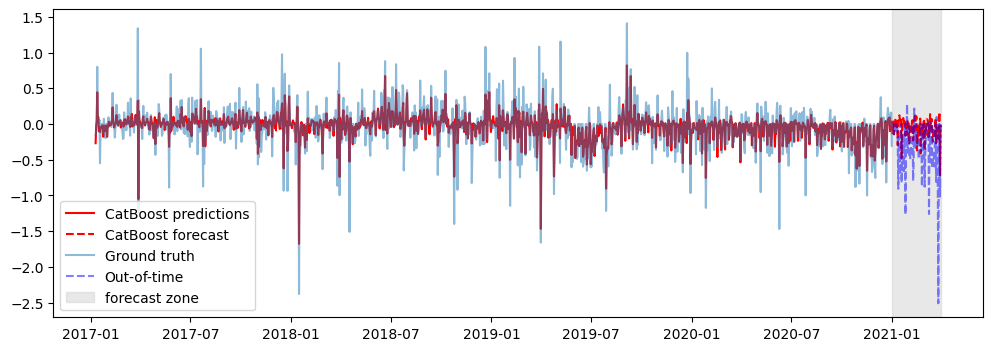

In [44]:
plt.figure(figsize=(12, 4))
plt.plot(train_predictions, color='r', label='CatBoost predictions')
plt.plot(test_predictions, color='r', linestyle='--', label='CatBoost forecast')
plt.plot(y_train, label='Ground truth', alpha=0.5)
plt.plot(y_test, color='b', label='Out-of-time', linestyle='--', alpha=0.5)
forecast_start = y_test.index[0]
forecast_end = y_test.index[-1]
plt.axvspan(forecast_start, forecast_end, alpha=0.5, color='lightgrey', label='forecast zone')
plt.legend();

In [47]:
catboost_model.save_model('../data/artifacts/catboost_regressor.cbm')
X_train_opt.to_csv('../data/train.csv')
y_train.to_csv('../data/train_y.csv')
X_test_opt.to_csv('../data/test.csv')
y_test.to_csv('../data/test_y.csv')